In [372]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Vehicle Loan Default Prediction

Financial institutions incur significant losses due to the default of vehicle loans. This has led to the tightening up of vehicle loan underwriting and increased vehicle loan rejection rates. The need for a better credit risk scoring model is also raised by these institutions. This warrants a study to estimate the determinants of vehicle loan default. A financial institution has hired you to accurately predict the probability of loanee/borrower defaulting on a vehicle loan in the first EMI (Equated Monthly Instalments) on the due date.


Following Information regarding the loan and loanee are provided in the datasets:
- `Loanee Information` (Demographic data like age, Identity proof etc.)
- `Loan Information` (Disbursal details, loan to value ratio etc.)
- `Bureau data & history` (Bureau score, number of active accounts, the status of other loans, credit history etc.) 

Doing so will ensure that clients capable of repayment are not rejected and important determinants can be identified which can be further used for minimising the default rates.  

Evaluation metric is _AUC ROC_ score

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
from scipy import stats
import re
import gc

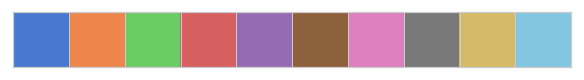

In [105]:
# set matplotlib ploting styles
sns.set()
sns.set_style('whitegrid')
sns.set_palette('muted')
sns.palplot(sns.color_palette())

In [107]:
c = sns.color_palette()
c_b = c[0]; c_o = c[1]; c_g = c[2]; c_r = c[3]; c_p = c[4]

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# load data
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [7]:
def show_all_pandas(df, nrow=None, ncol=None):
    with pd.option_context('display.max_rows', nrow, 'display.max_columns', ncol):
        display(df)

## Genral info about data

In [8]:
show_all_pandas(train_df.head())

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [11]:
show_all_pandas(test_df.head())

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


In [9]:
print("Train shape : ", train_df.shape)

Train shape :  (233154, 41)


In [12]:
print("Test sahpe: ", test_df.shape)

Test sahpe:  (112392, 40)


In [27]:
# missing values info function
def missing_info(df):    
    x = df.isnull().sum()[(df.isnull().sum() > 0)]
    d = pd.DataFrame(x, columns=['missing values'])
    d['% of missing values'] = np.round((x/df.shape[0]) * 100, decimals=2)
    return d

In [28]:
# missing values in train set
missing_info(train_df)

,missing values,% of missing values
Employment.Type,7661,3.29


- Only Employment.Type has missing values in train dataset, total 7661.

In [29]:
# missing values in test set
missing_info(test_df)

,missing values,% of missing values
Employment.Type,3443,3.06


- Only Employment.Type has missing values in test dataset, total 3443.

In [14]:
# Statistics of train dataset
train_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UniqueID,233154,NaN,NaN,NaN,535918,68315.7,417428,476786,535978,595040,671084
disbursed_amount,233154,NaN,NaN,NaN,54357,12971.3,13320,47145,53803,60413,990572
asset_cost,233154,NaN,NaN,NaN,75865.1,18944.8,37000,65717,70946,79201.8,1.62899e+06
ltv,233154,NaN,NaN,NaN,74.7465,11.4566,10.03,68.88,76.8,83.67,95
branch_id,233154,NaN,NaN,NaN,72.9361,69.835,1,14,61,130,261
supplier_id,233154,NaN,NaN,NaN,19638.6,3491.95,10524,16535,20333,23000,24803
manufacturer_id,233154,NaN,NaN,NaN,69.0281,22.1413,45,48,86,86,156
Current_pincode_ID,233154,NaN,NaN,NaN,3396.88,2238.15,1,1511,2970,5677,7345
Date.of.Birth,233154,15433,01-01-88,2173,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Employment.Type,225493,2,Self employed,127635,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Statistics of test data
test_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UniqueID,112392,NaN,NaN,NaN,711742,33492.2,654115,682659,711522,740851,769909
disbursed_amount,112392,NaN,NaN,NaN,56076.8,13123.7,11613,48849,55359,62147,940690
asset_cost,112392,NaN,NaN,NaN,77186.4,18271.5,40117,67510,72584,80040,1.27155e+06
ltv,112392,NaN,NaN,NaN,75.3103,11.0064,10.03,69.97,77.78,83.74,95
branch_id,112392,NaN,NaN,NaN,78.9026,71.4696,1,15,67,136,261
supplier_id,112392,NaN,NaN,NaN,19843.3,3555.3,10524,16633,20675,23170,24901
manufacturer_id,112392,NaN,NaN,NaN,68.366,22.1373,45,45,86,86,155
Current_pincode_ID,112392,NaN,NaN,NaN,3014,2223.22,1,1312,2412,5092,7345
Date.of.Birth,112392,14052,01-01-88,1057,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Employment.Type,108949,2,Self employed,59794,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Univariate Analysis

We are going to look at all variables individually and with target variable (loan default).

 

### `UniqueID` - unique id for loans

In [16]:
train_df['UniqueID'].nunique()

233154

In [17]:
test_df['UniqueID'].nunique()

112392

In [18]:
len(set(train_df['UniqueID'].unique()).intersection(set(test_df['UniqueID'].unique())))

0

- Any unique id is not repeating for train and test data. No Unique id of test data is present in train data.

- We can't use this column for model buliding.

### `loan_default` - (Target variable) loan default or not

data type - categorical  
0 - loan is not defaulted  
1 - loan is defaulted 

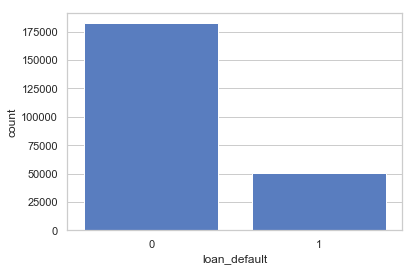

In [108]:
sns.countplot(train_df['loan_default'], color=c_b)
plt.show()

In [20]:
train_df['loan_default'].value_counts(normalize=True)

0    0.782929
1    0.217071
Name: loan_default, dtype: float64

- 21.7 % loans are defaulted.

### `disbursed_amount` - Disbursed amount for a loan

data type - numerical

In [454]:
# function for ploting various plots for numerial data
def plot_num_dis(df, col, target, exclude=[], col_name=None, target_name=None):
    if not col_name:
        col_name = col
    if not target_name:
        target_name = target
    
    if 'main' not in exclude:
        fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,4))
        fig.suptitle(col_name, fontsize=16, y=1.01)
        sns.distplot(df[col], kde=False, ax=ax1)
        ax1.set(xlabel=col, ylabel='Count', title=col_name)
        stats.probplot(df[col].values, dist=stats.norm, plot=ax2)
        ax2.set(title='Probability plot of ' + col_name)

    if 'logt' not in exclude:
        fig, ax = plt.subplots(ncols=2, figsize=(15,4))
        fig.suptitle('Log transformation', fontsize=16, y=1.01)
        sns.distplot(np.log(df[col].values + 1), kde=False, ax=ax[0])
        ax[0].set(title=('Log transformed ' + col_name), xlabel=(col+ ' (Log)'), ylabel='Count')
        stats.probplot(np.log(df[col].values + 1), dist=stats.norm, plot=ax[1])
        ax[1].set(title='Probability plot of Log('+ col_name +')')

    if 'bc' not in exclude:
        fig, ax = plt.subplots(ncols=2, figsize=(15,4))
        fig.suptitle('Box-Cox transformation', fontsize=16, y=1.01)
        x = stats.boxcox(df[col].values + 1)
        stats.probplot(x[0], dist=stats.norm, plot=ax[0])
        ax[0].set(title='Probability plot of Box-Cox (lambda '+ str(np.round(x[1], decimals=2)) +') transformed '+ col_name)
        stats.boxcox_normplot((df[col].values + 1), -20, 20 ,plot=ax[1])
        ax[1].set(title='Box-Cox normality plot of ' + col_name)
        ax[1].axvline(x[1], color='r')

    if 'logb' not in exclude:
        fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
        fig.suptitle('Log Bins', fontsize=16, y=1.01)
        x = np.floor(np.log(df[col].values + 1)).astype(int)
        sns.countplot(x, ax=ax[0], color=c_b)
        ax[0].set(title='Bins based on Floor(log('+ col_name +'))', xlabel='bin')
        x = pd.DataFrame({'col': x, 'target': df[target]}).groupby(['col'])['target'].mean()
        sns.barplot(x.index, x.values, color=c_b, ax=ax[1])
        ax[1].set(title='Probability of ' + target_name + ' for each log bins', xlabel='bin', ylabel='probability')

    if 'qb' not in exclude:
        fig, ax = plt.subplots(figsize=(15, 4))
        fig.suptitle('Quantile Bins', fontsize=16, y=1.01)
        sns.countplot(pd.qcut(df[col], q=10), hue=df[target], ax=ax)
        ax.set(title='quartile bins (10) by ' +  target_name, xlabel='bin')
        plt.xticks(rotation=90)

    if 'kde' not in exclude:
        facet = sns.FacetGrid(df, hue = target, size=4, aspect=3)
        facet.fig.suptitle((col_name + ' distribution' + ' by ' + target_name +' Status'), fontsize=16, y=1.01)
        facet.map(sns.kdeplot, col, shade=True)
        facet.add_legend()

    if 'bp' not in exclude:
        fig, ax = plt.subplots(figsize=(15,5))
        fig.suptitle((col_name + ' boxplot' + ' by ' + target_name + ' Status'), fontsize=16, y=1.01)
        sns.boxplot(x=col, y=target, data=df, orient='h', ax=ax)
        ax.set(ylabel=target)

    plt.tight_layout()
    plt.show()

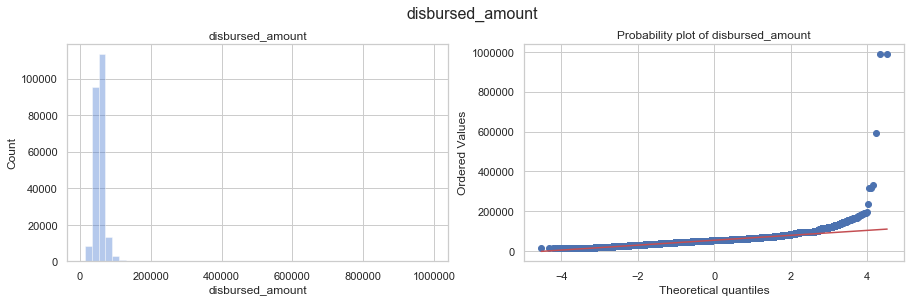

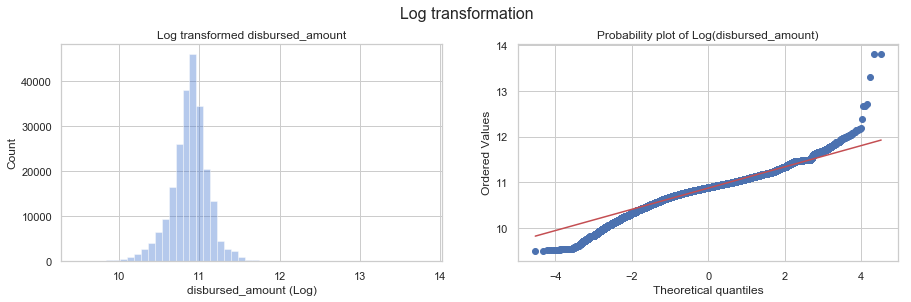

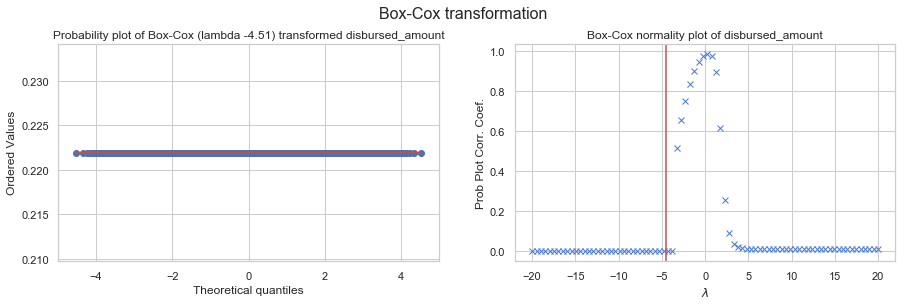

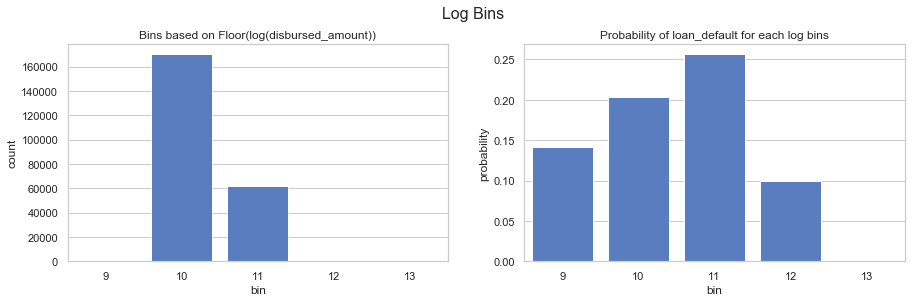

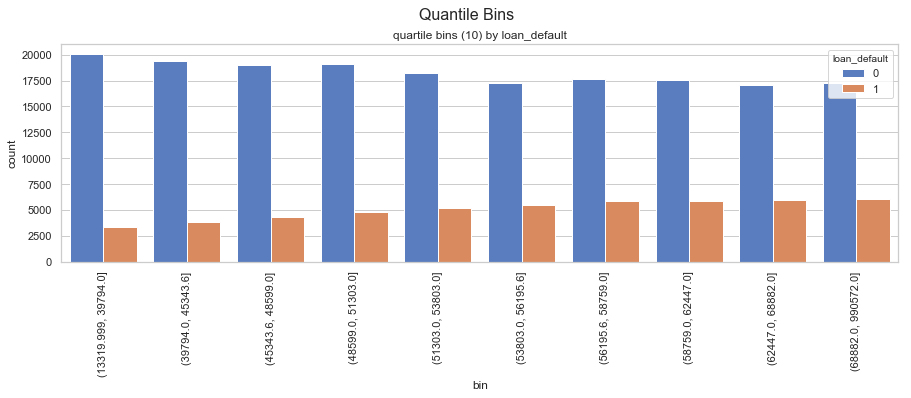

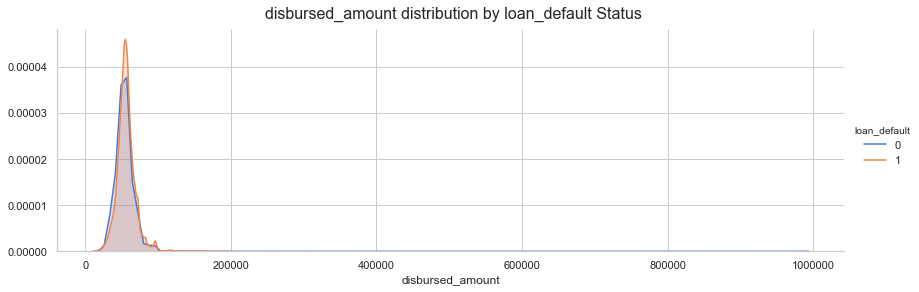

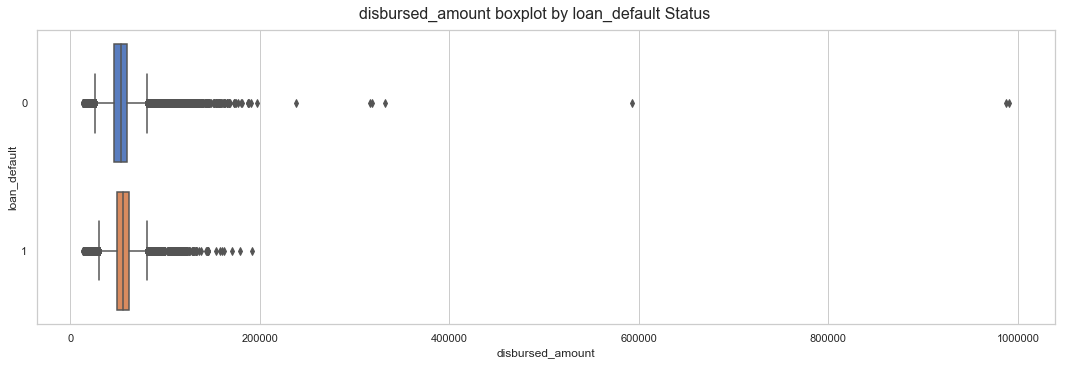

In [455]:
plot_num_dis(train_df, 'disbursed_amount', 'loan_default')

In [335]:
train_df.groupby(['loan_default'])['disbursed_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_default,,,,,,,,
0,182543.0,53826.471111,13140.699007,13320.0,46369.0,53303.0,59947.0,990572.0
1,50611.0,56270.473869,12150.255527,13369.0,49303.0,55459.0,61947.0,191392.0


In [444]:
def chi_test(col1, col2, print_ctable=False):
    c_table = pd.crosstab(col1, col2)
    if print_ctable:
        print("contigency table\n")
        print(c_table)
    stat, p, dof, expected = stats.chi2_contingency(c_table)
    print('\ndegree of freedom: ', dof)
    if print_ctable:
        print("\n expected \n")
        print(expected)
    # interpret test-statistic
    prob = 0.95
    critical = stats.chi2.ppf(prob, dof)
    print('\nprobability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

In [327]:
chi_test(pd.qcut(train_df['disbursed_amount'], 10, labels=False), train_df['loan_default'], True)

contigency table

loan_default          0     1
disbursed_amount             
0                 20025  3380
1                 19429  3797
2                 19023  4302
3                 19064  4792
4                 18239  5162
5                 17229  5450
6                 17629  5864
7                 17562  5880
8                 17087  5947
9                 17256  6037

degree of freedom:  9

 expected 

[[18324.45042761  5080.54957239]
 [18184.30615816  5041.69384184]
 [18261.81611724  5063.18388276]
 [18677.55135233  5178.44864767]
 [18321.3187121   5079.6812879 ]
 [17756.04406101  4922.95593899]
 [18393.34816902  5099.65183098]
 [18353.41879616  5088.58120384]
 [18033.98381327  5000.01618673]
 [18236.7623931   5056.2376069 ]]

probability=0.950, critical=16.919, stat=2151.882
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


In [325]:
chi_test(np.floor(np.log(train_df['disbursed_amount'])), train_df['loan_default'], True)

contigency table

loan_default           0      1
disbursed_amount               
9.0                  635    105
10.0              135693  34571
11.0               46185  15932
12.0                  27      3
13.0                   3      0

degree of freedom:  4

 expected 

[[5.79367371e+02 1.60632629e+02]
 [1.33304603e+05 3.69593972e+04]
 [4.86331932e+04 1.34838068e+04]
 [2.34878664e+01 6.51213361e+00]
 [2.34878664e+00 6.51213361e-01]]

probability=0.950, critical=9.488, stat=792.746
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


In [317]:
np.corrcoef(train_df['disbursed_amount'], train_df['loan_default'])[0][1]

0.07767492189723199

In [311]:
np.corrcoef(np.log(train_df['disbursed_amount']), train_df['loan_default'])[0][1]

0.08593880242256892

In [318]:
np.corrcoef(np.floor(np.log(train_df['disbursed_amount'])), train_df['loan_default'])[0][1]

0.05792812259229096

In [321]:
stats.spearmanr(train_df['disbursed_amount'], train_df['loan_default'])

SpearmanrResult(correlation=0.09288435655814552, pvalue=0.0)

In [322]:
stats.spearmanr(np.log(train_df['disbursed_amount']), train_df['loan_default'])

SpearmanrResult(correlation=0.09288435655814552, pvalue=0.0)

In [323]:
stats.spearmanr(np.floor(np.log(train_df['disbursed_amount'])), train_df['loan_default'])

SpearmanrResult(correlation=0.0579972131614532, pvalue=7.410133686260066e-173)

### `asset_cost` - cost of an asset (vehicle)

data type - numerical

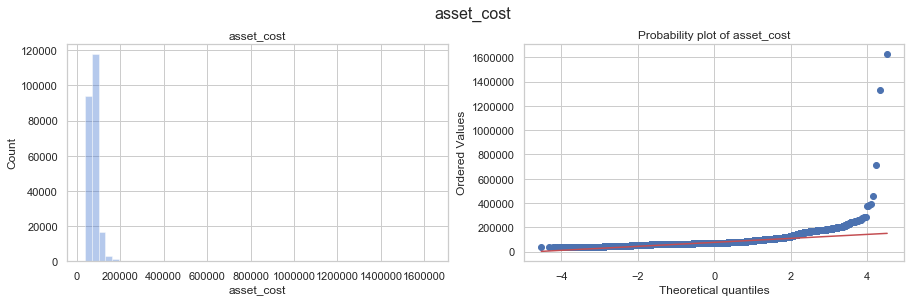

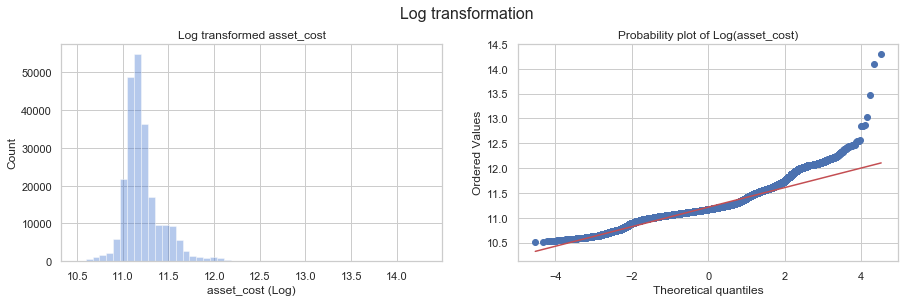

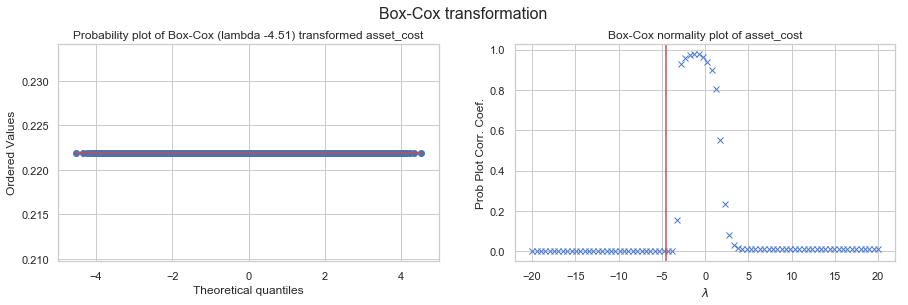

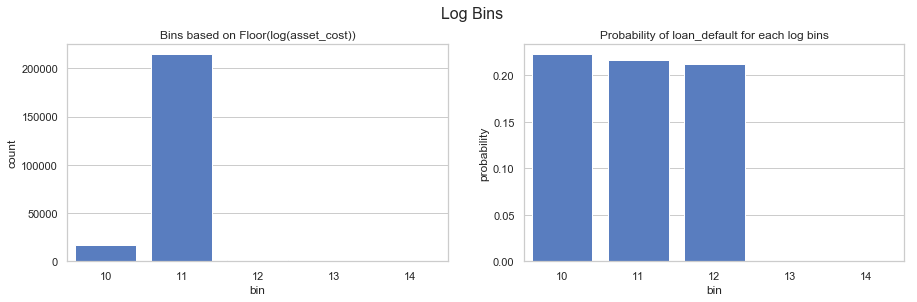

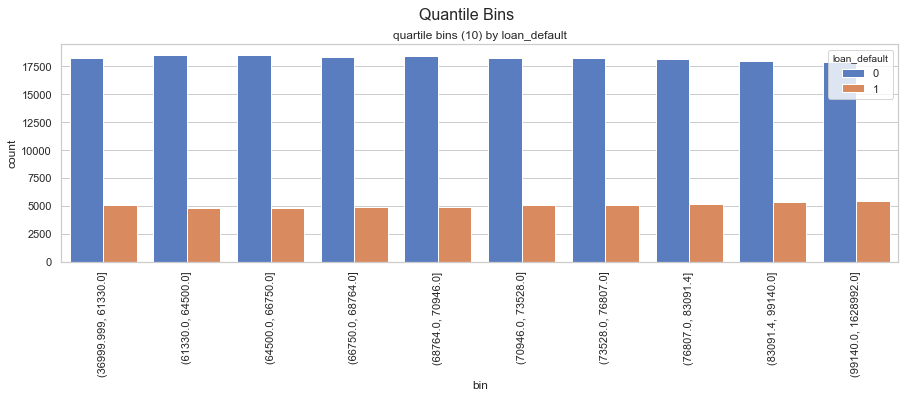

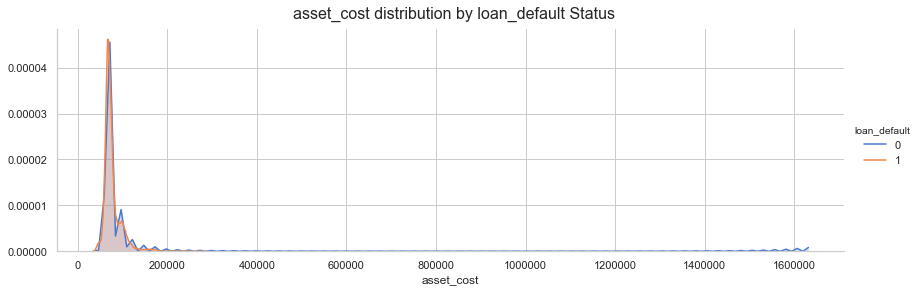

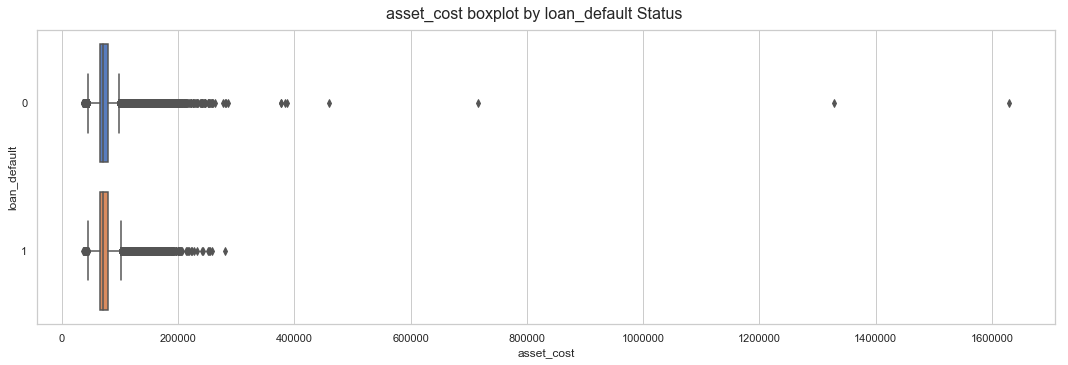

In [369]:
plot_num_dis(train_df, 'asset_cost', 'loan_default')

### `ltv` - Loan to asset value

data type - numerical

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, 

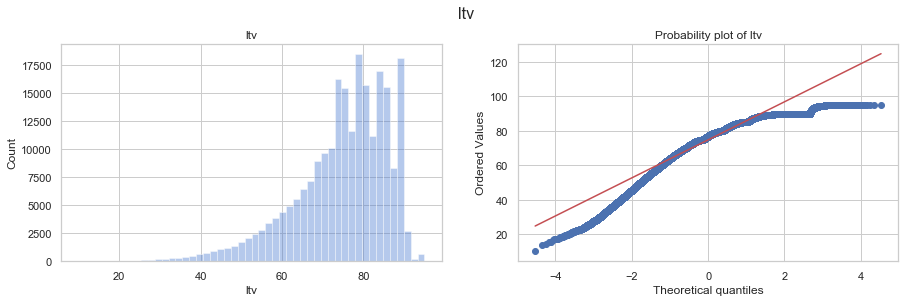

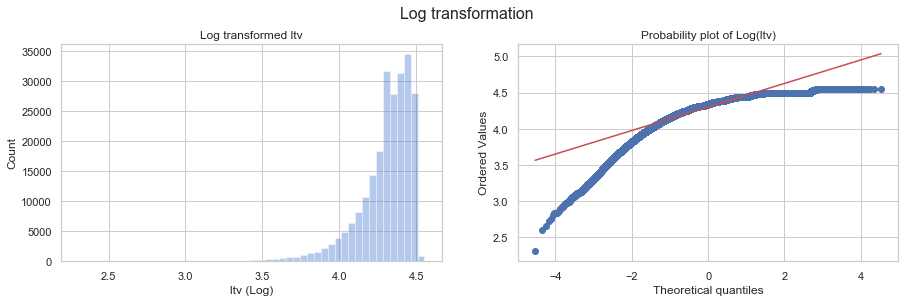

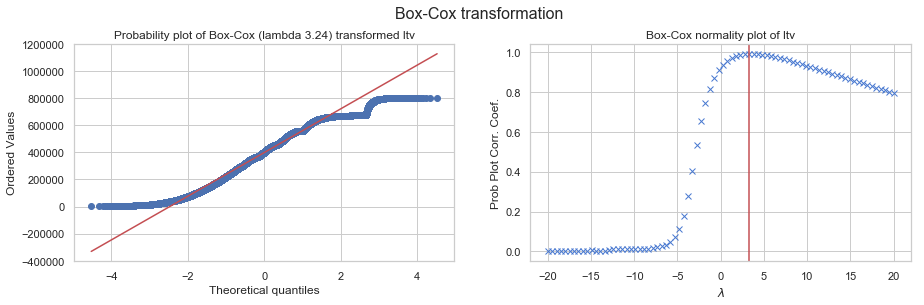

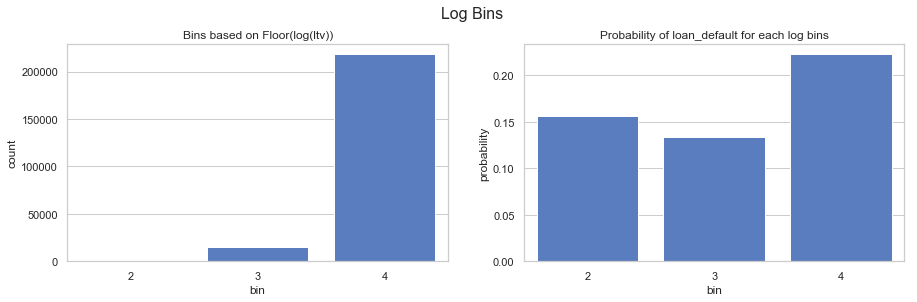

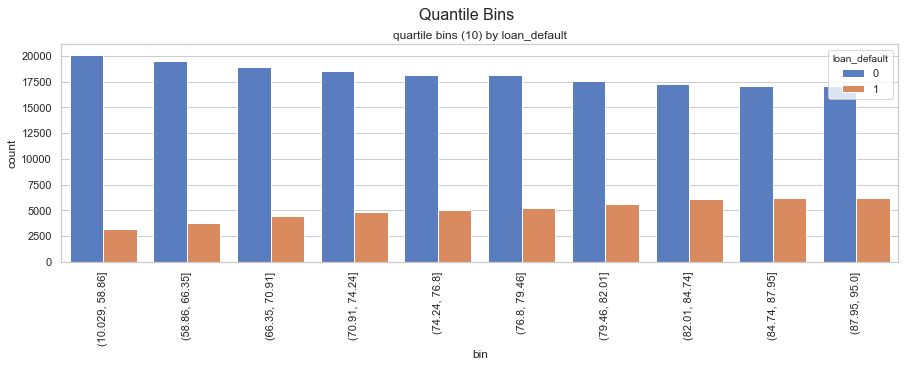

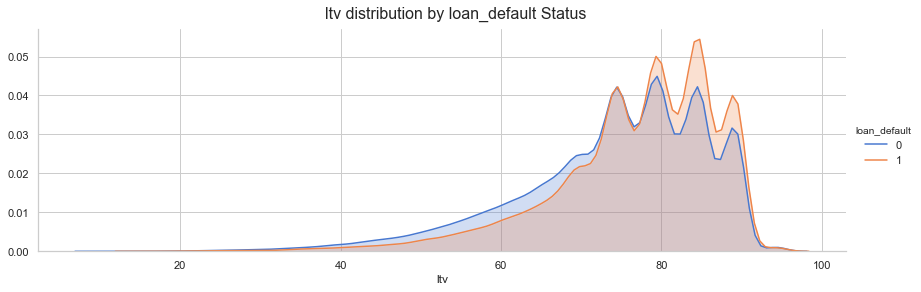

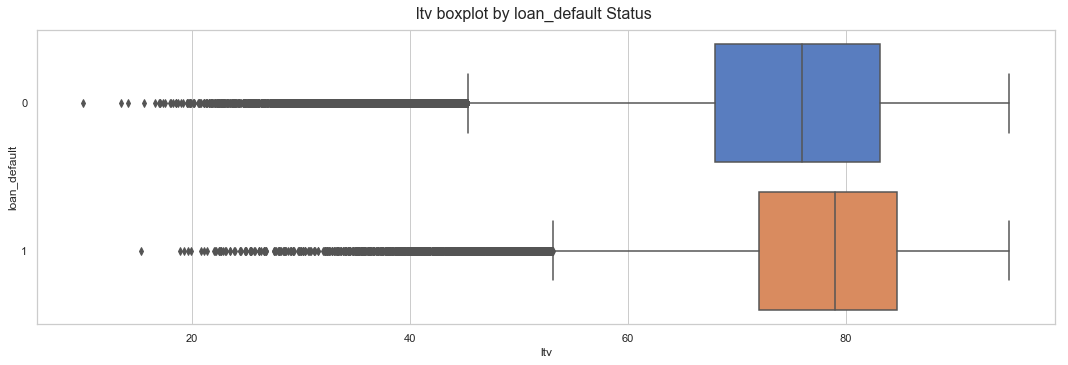

In [370]:
plot_num_dis(train_df, 'ltv', 'loan_default')

### `branch_id` - branch id of the finantial institution

data type - categorical

In [348]:
print("Total unique branch_id in train data: ", train_df['branch_id'].nunique())
print("Total unique branch_id in test data: ", test_df['branch_id'].nunique())
print("number of new branch_id in test data: ", len(set(train_df['branch_id'].unique()).union(set(test_df['branch_id']))) - test_df['branch_id'].nunique())

Total unique branch_id in train data:  82
Total unique branch_id in test data:  82
number of new branch_id in test data:  0


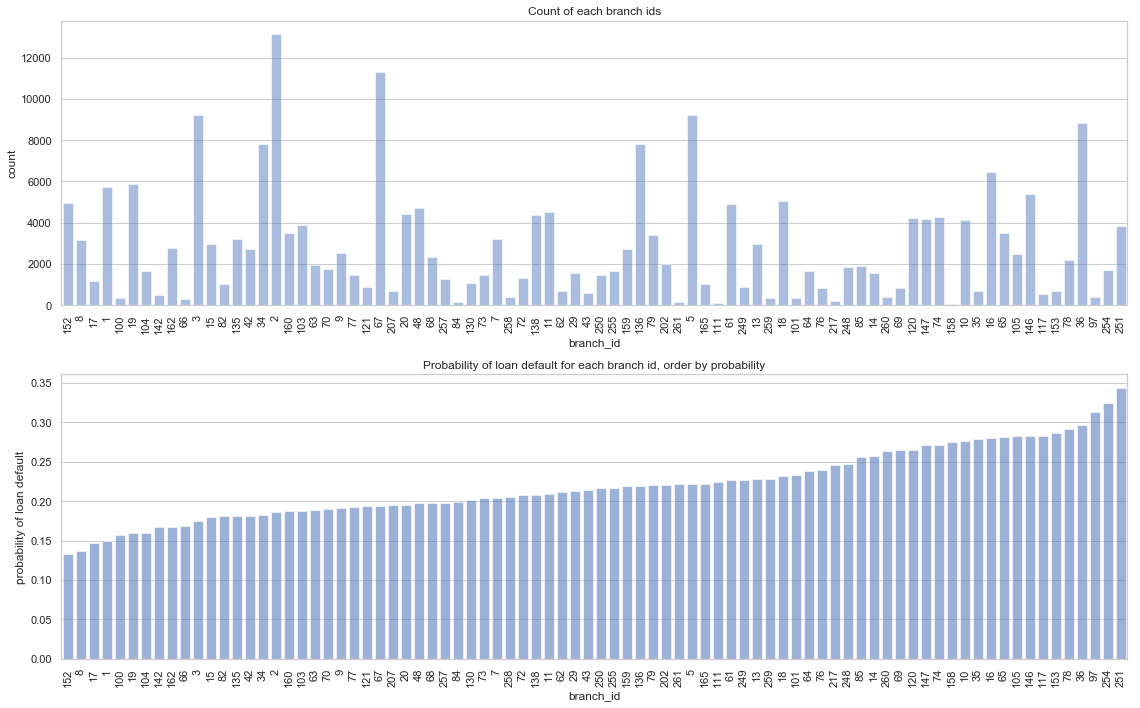

In [270]:
x = train_df.groupby('branch_id')['loan_default'].mean()
x = x.sort_values()
fig, ax = plt.subplots(nrows=2, figsize=(16, 10))
sns.countplot(train_df['branch_id'], color=c_b, order=x.index, ax=ax[0], alpha=0.5)
ax[0].set(title='Count of each branch ids')
sns.barplot(x.index, x.values, orient = "v", order=x.index, color=c_b, ax=ax[1], alpha=0.6)
ax[1].set(ylabel='probability of loan default', title='Probability of loan default for each branch id, order by probability')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### `supplier_id` - supplier id of a vehicle supplier

data type - categorical

In [347]:
print("Total unique supplier_id in train data: ", train_df['supplier_id'].nunique())
print("Total unique supplier_id in test data: ", test_df['supplier_id'].nunique())
print("number of new supplier_id in test data: ", len(set(train_df['supplier_id'].unique()).union(set(test_df['supplier_id']))) - test_df['supplier_id'].nunique())

Total unique supplier_id in train data:  2953
Total unique supplier_id in test data:  2863
number of new supplier_id in test data:  226


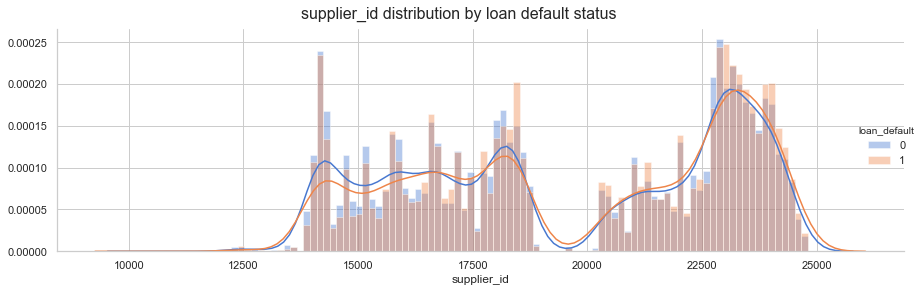

In [267]:
_, bins = np.histogram(train_df["supplier_id"], bins=100)
g = sns.FacetGrid(train_df, hue="loan_default", size=4, aspect=3)
g = g.map(sns.distplot, "supplier_id", bins=bins)
g.fig.suptitle('supplier_id distribution by loan default status', fontsize=16, y=1.01)
g.add_legend()
plt.tight_layout()
plt.show()

- Looks like loan default chances are higher for supplier id higher than 23000.

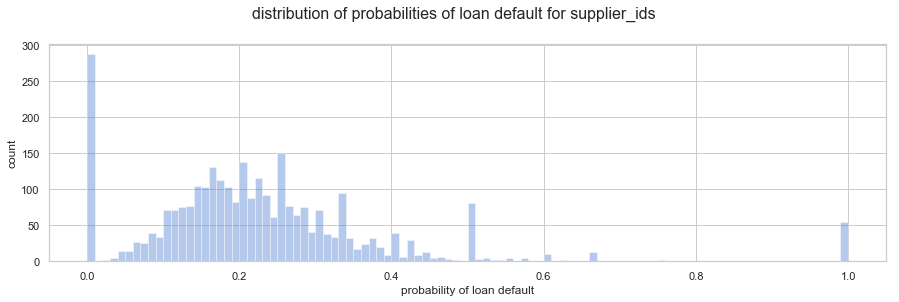

In [298]:
x = train_df.groupby(['supplier_id'])['loan_default'].mean()
fig, ax = plt.subplots(figsize=(15,4))
sns.distplot(x.values, kde=False, bins=100, ax=ax)
ax.set(xlabel='probability of loan default', ylabel='count')
fig.suptitle('distribution of probabilities of loan default for supplier_ids', fontsize=16, y=1.01)
plt.show()

- around 50 suppliers have probability of loan deafult 1.
- around 300 suppliers have loan default probability less than 0.05.
- most of the suppliers have loan default probability between 0.1 and 0.4.

### `manufacturer_id` - manufacturer id for vehicle manufacturers

data type - categorical

In [346]:
print("Total unique manufacturer_id in train data: ", train_df['manufacturer_id'].nunique())
print("Total unique manufacturer_id in test data: ", test_df['manufacturer_id'].nunique())
print("number of new manufacturer_id in test data: ", len(set(train_df['manufacturer_id'].unique()).union(set(test_df['manufacturer_id']))) - test_df['manufacturer_id'].nunique())

Total unique manufacturer_id in train data:  11
Total unique manufacturer_id in test data:  11
number of new manufacturer_id in test data:  1


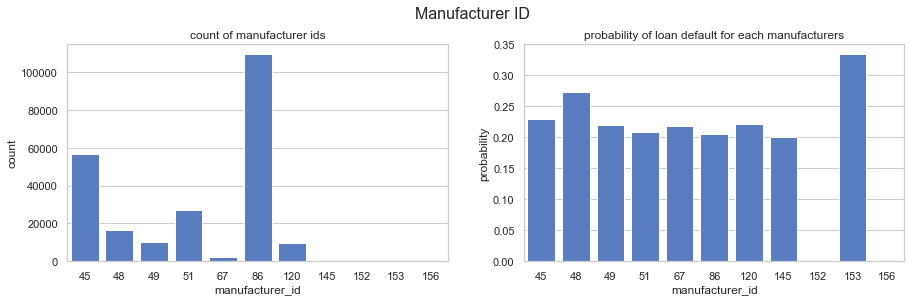

In [292]:
fig, ax = plt.subplots(ncols=2, figsize=(15,4))
sns.countplot(train_df['manufacturer_id'], color=c_b, ax=ax[0])
ax[0].set(title='count of manufacturer ids')
x = train_df.groupby(['manufacturer_id'])['loan_default'].mean()
sns.barplot(x.index, x.values, color=c_b, ax=ax[1])
ax[1].set(title='probability of loan default for each manufacturers', xlabel='manufacturer_id', ylabel='probability')
fig.suptitle('Manufacturer ID', fontsize=16, y=1.01)
plt.show()

- There are more than 100,000 borrowers who bought vehicle from manufacturer 86.
- only 6 vehicles are sold from manufacturer 152, and it has highest chance of loan default.
- manufacturer id 152 and 156 also has very less vehicles sold, and their chance of loan default is near zero.

### `Employee_code_ID` - Employee of the organization who logged the disbursement

data type - categorical

In [295]:
print("Total unique employees in train data: ", train_df['Employee_code_ID'].nunique())
print("Total unique employees in test data: ", test_df['Employee_code_ID'].nunique())
print("number of new employees in test data: ", len(set(train_df['Employee_code_ID'].unique()).union(set(test_df['Employee_code_ID']))) - test_df['Employee_code_ID'].nunique())

Total unique employees in train data:  3270
Total unique employees in test data:  3143
number of new employees in test data:  255


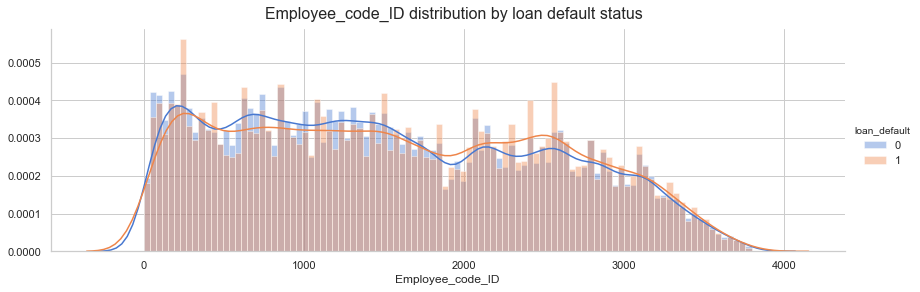

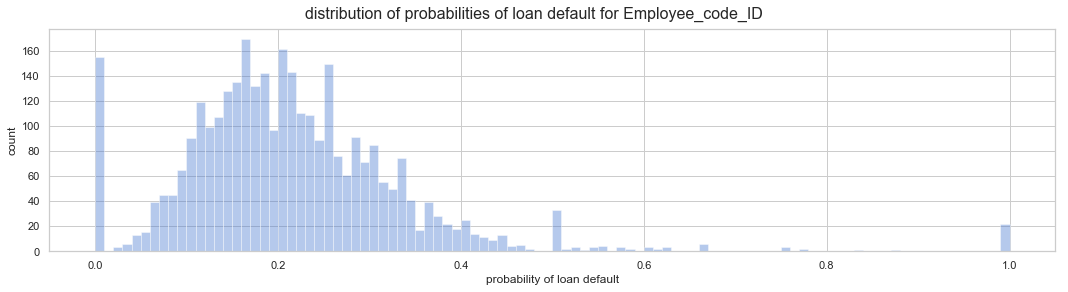

In [297]:
_, bins = np.histogram(train_df["Employee_code_ID"], bins=100)
g = sns.FacetGrid(train_df, hue="loan_default", size=4, aspect=3)
g = g.map(sns.distplot, "Employee_code_ID", bins=bins)
g.fig.suptitle('Employee_code_ID distribution by loan default status', fontsize=16, y=1.01)
g.add_legend()

x = train_df.groupby(['Employee_code_ID'])['loan_default'].mean()
fig, ax = plt.subplots(figsize=(15,4))
sns.distplot(x.values, kde=False, bins=100, ax=ax)
ax.set(xlabel='probability of loan default', ylabel='count')
fig.suptitle('distribution of probabilities of loan default for Employee_code_ID', fontsize=16, y=1.01)

plt.tight_layout()
plt.show()

### `State_ID` - State in which the disbursement branch is located

data type - categorical

In [337]:
print("Total unique State_ID in train data: ", train_df['State_ID'].nunique())
print("Total unique State_ID in test data: ", test_df['State_ID'].nunique())
print("number of new State_ID in test data: ", len(set(train_df['State_ID'].unique()).union(set(test_df['State_ID']))) - test_df['State_ID'].nunique())

Total unique State_ID in train data:  22
Total unique State_ID in test data:  22
number of new State_ID in test data:  0


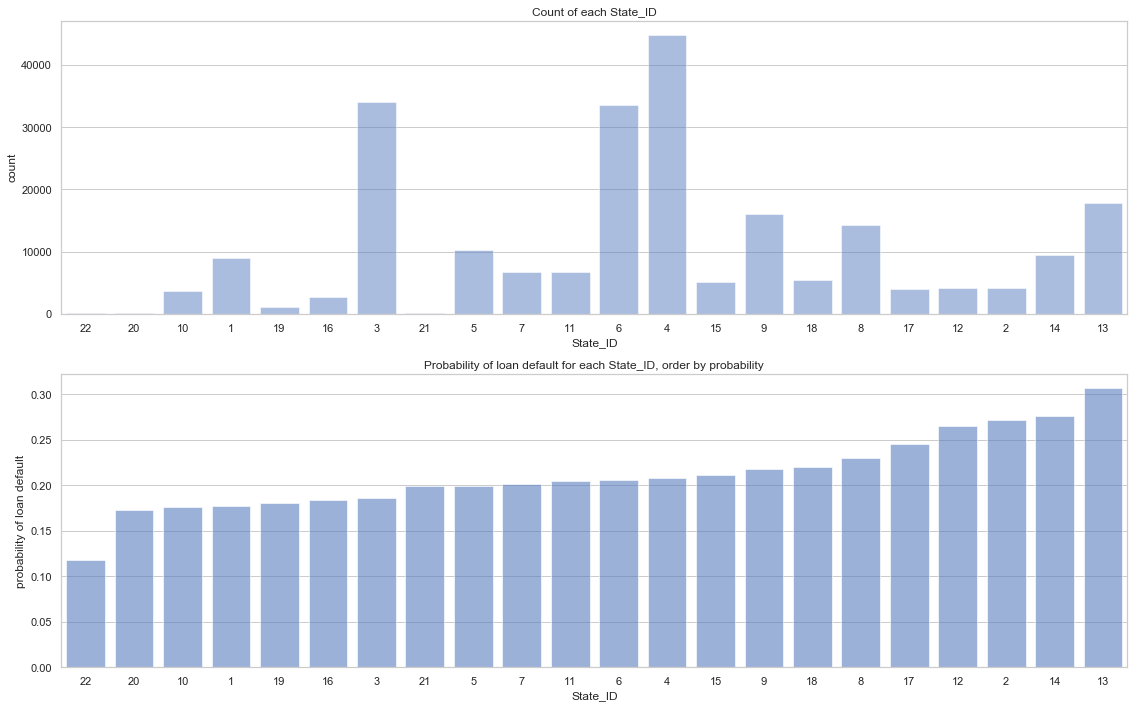

In [338]:
x = train_df.groupby('State_ID')['loan_default'].mean()
x = x.sort_values()
fig, ax = plt.subplots(nrows=2, figsize=(16, 10))
sns.countplot(train_df['State_ID'], color=c_b, order=x.index, ax=ax[0], alpha=0.5)
ax[0].set(title='Count of each State_ID')
sns.barplot(x.index, x.values, orient = "v", order=x.index, color=c_b, ax=ax[1], alpha=0.6)
ax[1].set(ylabel='probability of loan default', title='Probability of loan default for each State_ID, order by probability')

plt.tight_layout()
plt.show()

### `Current_pincode_ID` - Current pincode of the customer

data type - categorical

In [336]:
print("Total unique Current_pincode_ID in train data: ", train_df['Current_pincode_ID'].nunique())
print("Total unique Current_pincode_ID in test data: ", test_df['Current_pincode_ID'].nunique())
print("number of new Current_pincode_ID in test data: ", len(set(train_df['Current_pincode_ID'].unique()).union(set(test_df['Current_pincode_ID']))) - test_df['Current_pincode_ID'].nunique())

Total unique Current_pincode_ID in train data:  6698
Total unique Current_pincode_ID in test data:  6202
number of new Current_pincode_ID in test data:  894


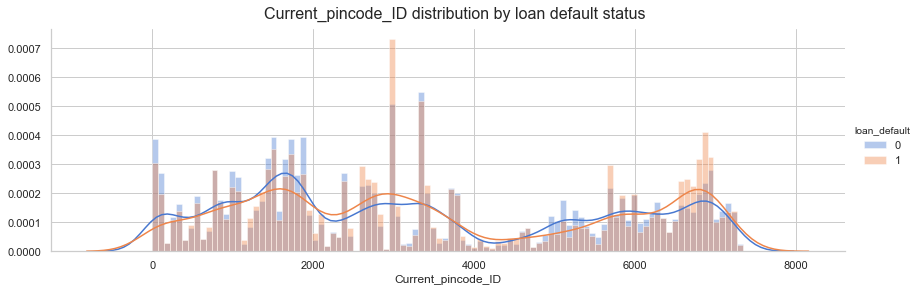

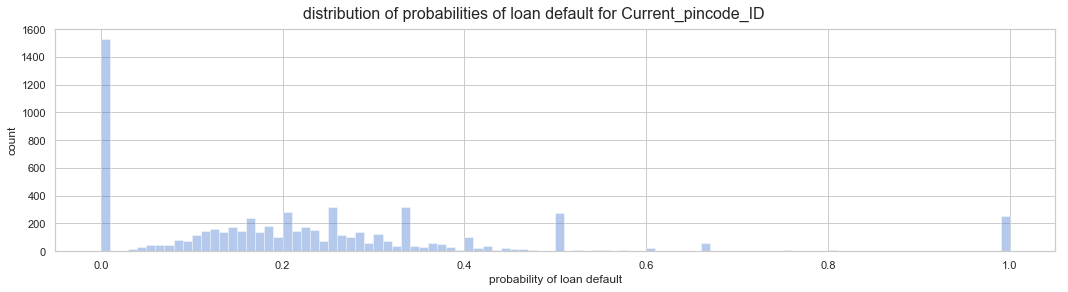

In [377]:
_, bins = np.histogram(train_df["Current_pincode_ID"], bins=100)
g = sns.FacetGrid(train_df, hue="loan_default", size=4, aspect=3)
g = g.map(sns.distplot, "Current_pincode_ID", bins=bins)
g.fig.suptitle('Current_pincode_ID distribution by loan default status', fontsize=16, y=1.01)
g.add_legend()

x = train_df.groupby(['Current_pincode_ID'])['loan_default'].mean()
fig, ax = plt.subplots(figsize=(15,4))
sns.distplot(x.values, kde=False, bins=100, ax=ax)
ax.set(xlabel='probability of loan default', ylabel='count')
fig.suptitle('distribution of probabilities of loan default for Current_pincode_ID', fontsize=16, y=1.01)

plt.tight_layout()
plt.show()

### `Employment.Type` - Employment Type of the customer (Salaried/Self Employed)

data type - categorical

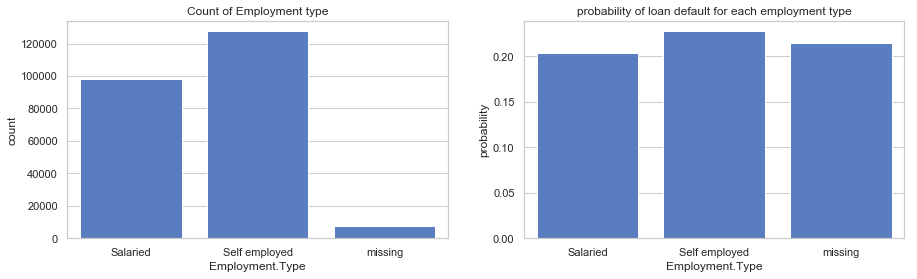

In [345]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
sns.countplot(train_df['Employment.Type'].fillna('missing'), color=c_b, ax=ax[0])
ax[0].set(title="Count of Employment type")
x = train_df[['Employment.Type', 'loan_default']].fillna('missing').groupby(['Employment.Type'])['loan_default'].mean()
sns.barplot(x.index, x.values, color=c_b, ax=ax[1])
ax[1].set(title='probability of loan default for each employment type', ylabel='probability', xlabel='Employment.Type')
plt.show()

### `DisbursalDate` - Date of disbursement

data type - date

In [328]:
# Train DisbursalDate min
train_df['DisbursalDate'] = pd.to_datetime(train_df['DisbursalDate'], dayfirst=True)
print("Starting disbursal date in train data: ", train_df['DisbursalDate'].min())
print("Ending disbursal date in train data: ", train_df['DisbursalDate'].max())

Starting disbursal date in train data:  2018-08-01 00:00:00
Ending disbursal date in train data:  2018-10-31 00:00:00


In [329]:
# Test DisbursalDate max
test_df['DisbursalDate'] = pd.to_datetime(test_df['DisbursalDate'], dayfirst=True)
print("Starting disbursal date in test data: ", test_df['DisbursalDate'].min())
print("Ending disbursal date in test data: ", test_df['DisbursalDate'].max())

Starting disbursal date in test data:  2018-11-03 00:00:00
Ending disbursal date in test data:  2018-11-30 00:00:00


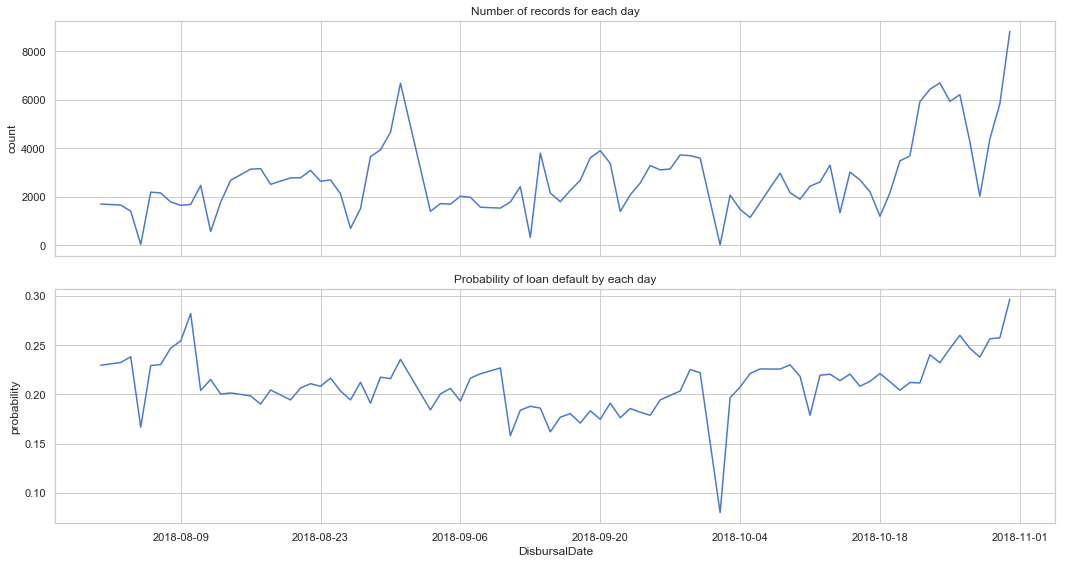

In [333]:
x = train_df.groupby(['DisbursalDate'])['loan_default'].agg(['mean', 'count'])
fig, ax = plt.subplots(nrows=2, figsize=(15,8), sharex=True)
sns.lineplot(x=x.index, y=x['count'], ax=ax[0])
ax[0].set(title='Number of records for each day', ylabel='count')
sns.lineplot(x=x.index, y=x['mean'], ax=ax[1])
ax[1].set(title="Probability of loan default by each day", ylabel='probability')

plt.tight_layout()
plt.show()

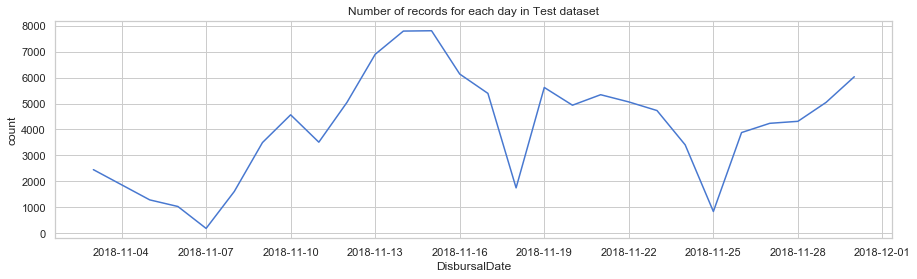

In [340]:
x = test_df.groupby(['DisbursalDate'])['UniqueID'].agg(['count'])
fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(x=x.index, y=x['count'], ax=ax)
ax.set(title='Number of records for each day in Test dataset', ylabel='count')
plt.show()

### `Date.of.Birth` - Date of birth of the customer

data type - date

In [350]:
train_df['Date.of.Birth'] = pd.to_datetime(train_df['Date.of.Birth'], dayfirst=True)
train_df['Date.of.Birth'] = train_df['Date.of.Birth'].apply(lambda x: x.replace(year=x.year-100) if x.year > 2000 else x)
print("Starting DOB in train data: ", train_df['Date.of.Birth'].min())
print("Ending DOB in train data: ", train_df['Date.of.Birth'].max())

Starting DOB in train data:  1949-09-15 00:00:00
Ending DOB in train data:  2000-10-20 00:00:00


In [351]:
test_df['Date.of.Birth'] = pd.to_datetime(test_df['Date.of.Birth'], dayfirst=True)
test_df['Date.of.Birth'] = test_df['Date.of.Birth'].apply(lambda x: x.replace(year=x.year-100) if x.year > 2000 else x)
print("Starting DOB in train data: ", test_df['Date.of.Birth'].min())
print("Ending DOB in train data: ", test_df['Date.of.Birth'].max())

Starting DOB in train data:  1954-02-27 00:00:00
Ending DOB in train data:  2000-11-29 00:00:00


### `cus_age` - Age of customer 

New created feature

data type - numerical (years)

In [352]:
train_df['cus_age'] = np.floor((train_df['DisbursalDate'] - train_df['Date.of.Birth']).dt.days / 365.25).astype(np.int8)
test_df['cus_age'] = np.floor((test_df['DisbursalDate'] - test_df['Date.of.Birth']).dt.days / 365.25).astype(np.int8)

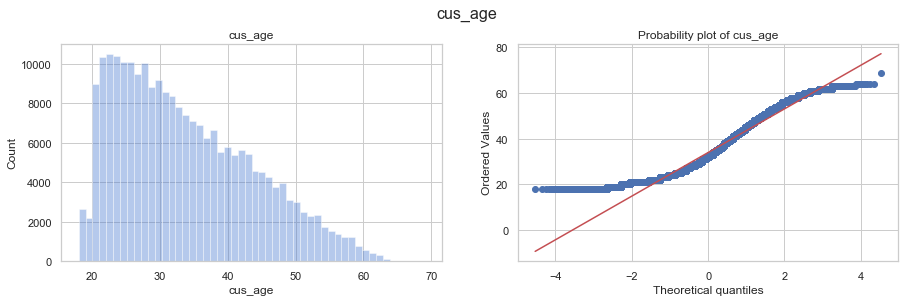

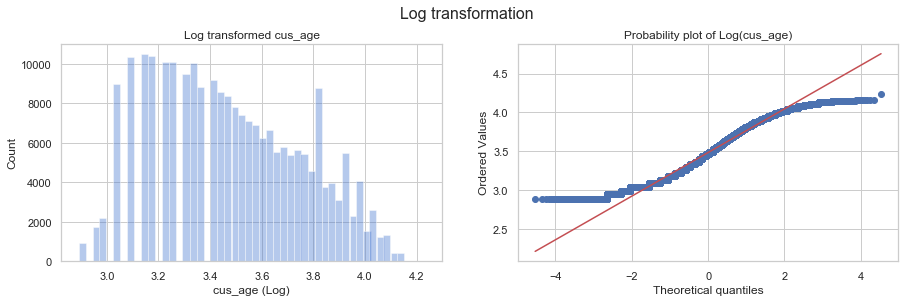

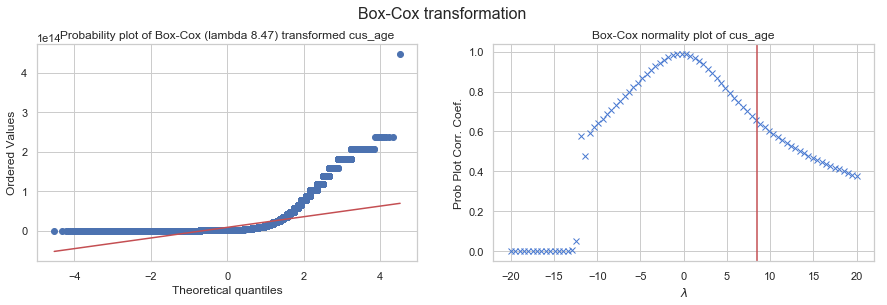

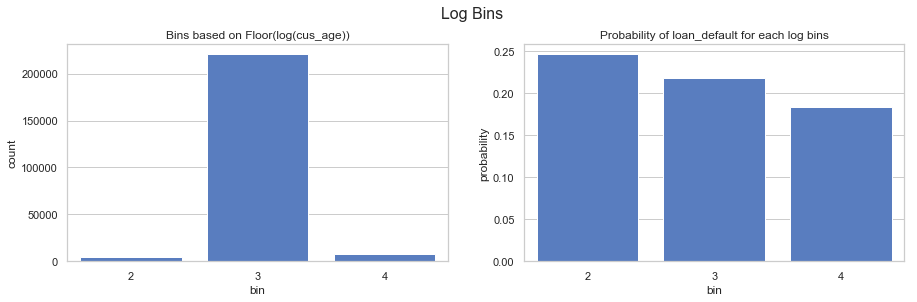

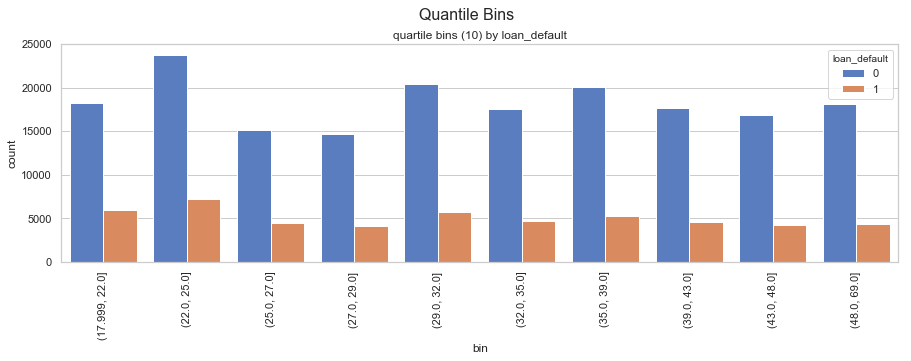

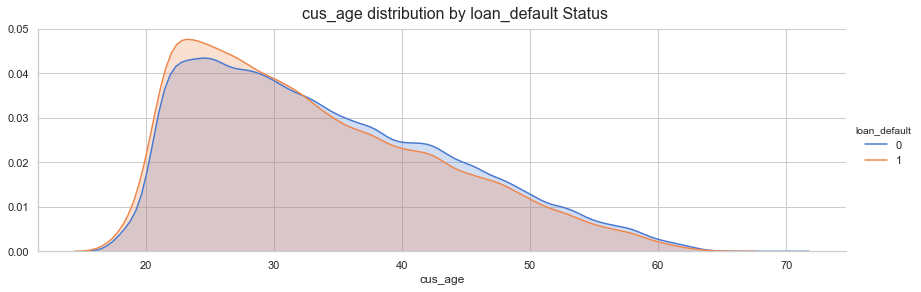

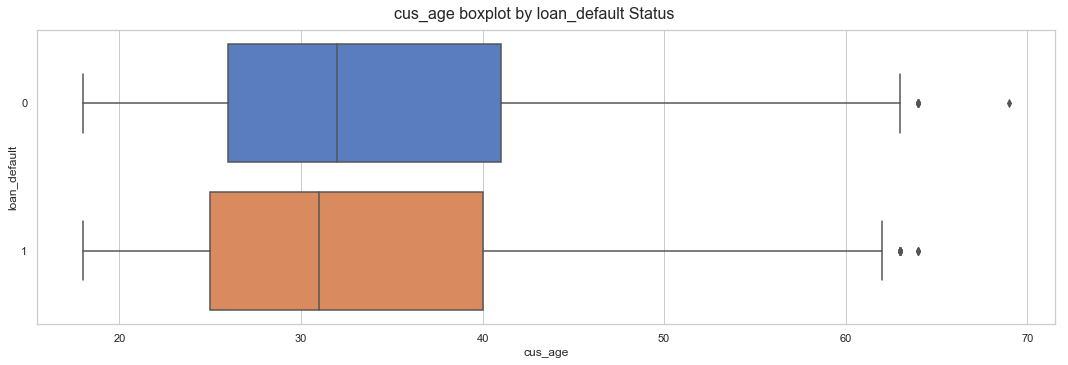

In [371]:
plot_num_dis(train_df, 'cus_age', 'loan_default')

### Identty Proofs

- `MobileNo_Avl_Flag`
- `Aadhar_flag`
- `PAN_flag`
- `Passport_flag`
- `Driving_flag`
- `VoterID_flag`

data type - binary categorical

1 - has that identity proof  
0 - does not have that identity proof

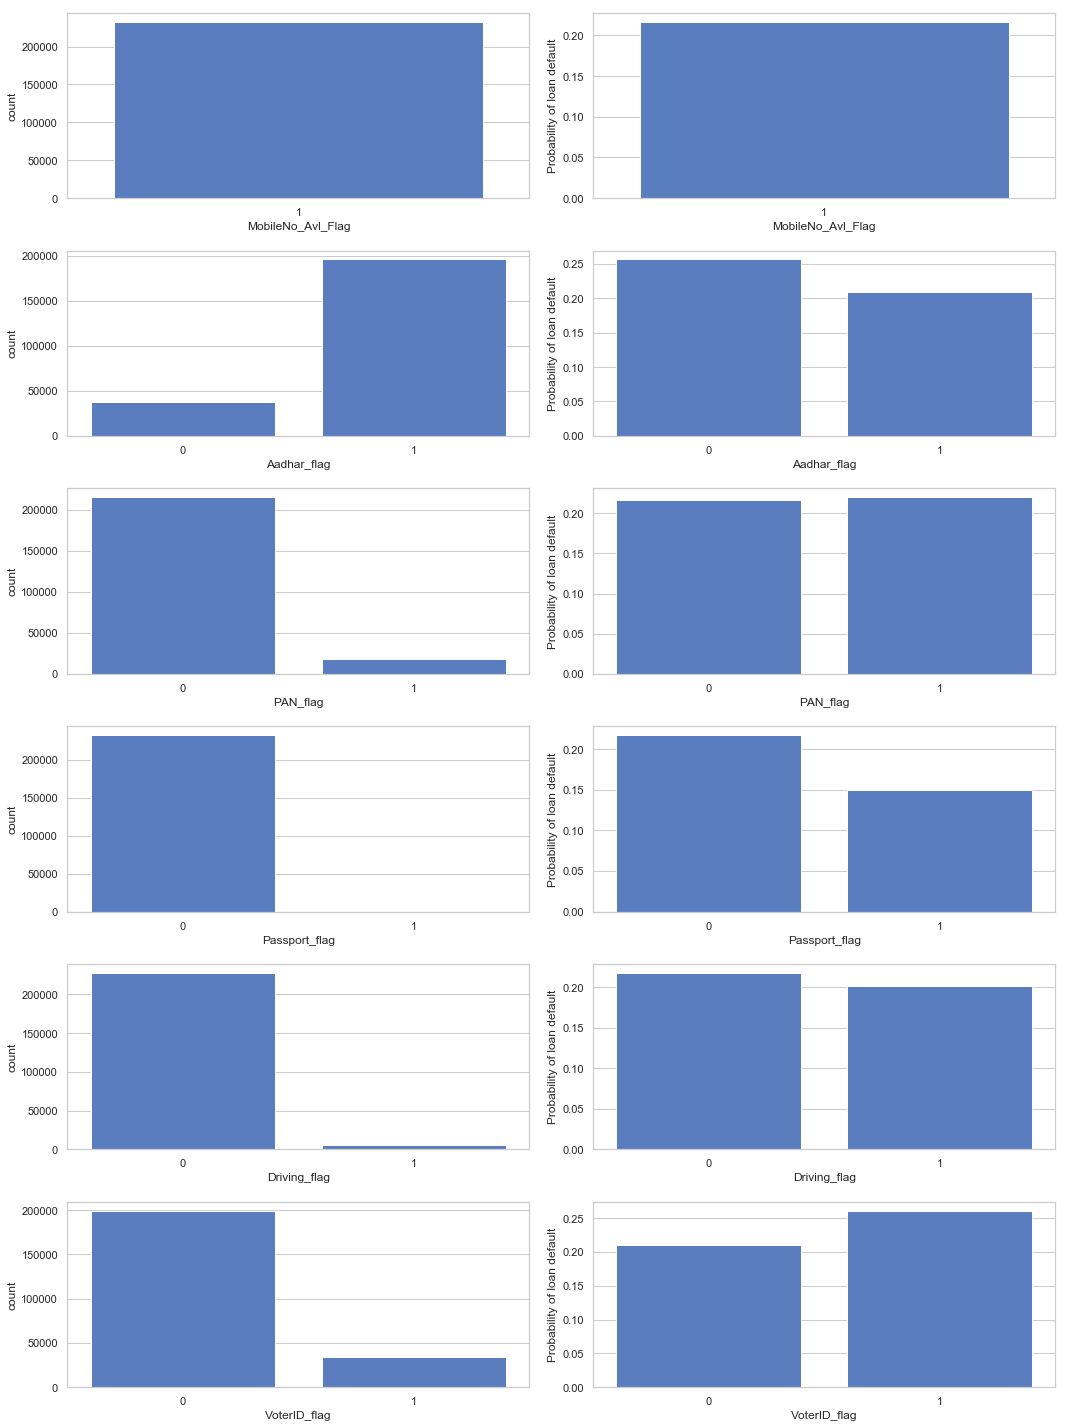

In [374]:
fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(15, 20))
identity_cols = ['MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'Passport_flag', 'Driving_flag', 'VoterID_flag']

for i, col in enumerate(identity_cols):
    x = train_df.groupby([col])['loan_default'].mean()
    sns.countplot(train_df[col], color=c_b, ax=ax[i][0])
    sns.barplot(x.index, x.values, color=c_b, ax=ax[i][1])
    ax[i][1].set(ylabel = 'Probability of loan default', xlabel=col)

plt.tight_layout()
plt.show()

### `PERFORM_CNS.SCORE.DESCRIPTION` - Bureau score description

data type - categorical

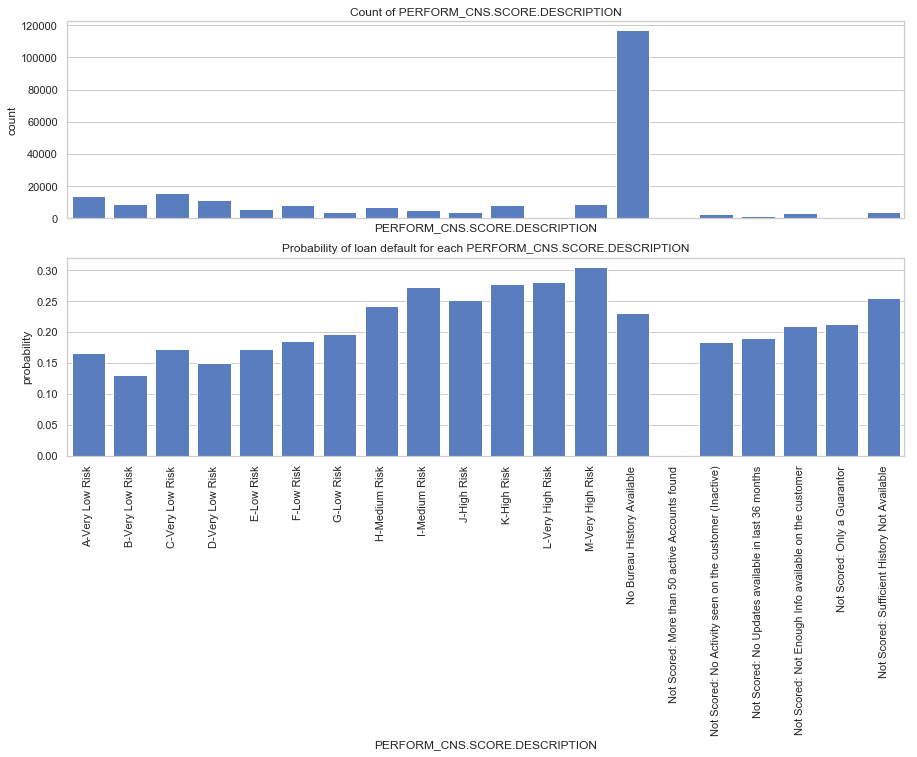

In [400]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 8), sharex=True)
x = train_df.groupby(['PERFORM_CNS.SCORE.DESCRIPTION'])['loan_default'].agg(['mean', 'count'])
sns.barplot(x.index, x['count'], color=c_b, ax=ax[0])
ax[0].set(title="Count of PERFORM_CNS.SCORE.DESCRIPTION", ylabel='count')
sns.barplot(x.index, x['mean'], color=c_b, ax=ax[1])
ax[1].set(title="Probability of loan default for each PERFORM_CNS.SCORE.DESCRIPTION", ylabel='probability')
plt.xticks(rotation=90)
plt.show()

- There are more than 1,10,000 applicants has not bureau info available.
- We can see that as risk increase chances of loan default also increase.
- We are going to put all Not scored categories into just one category.

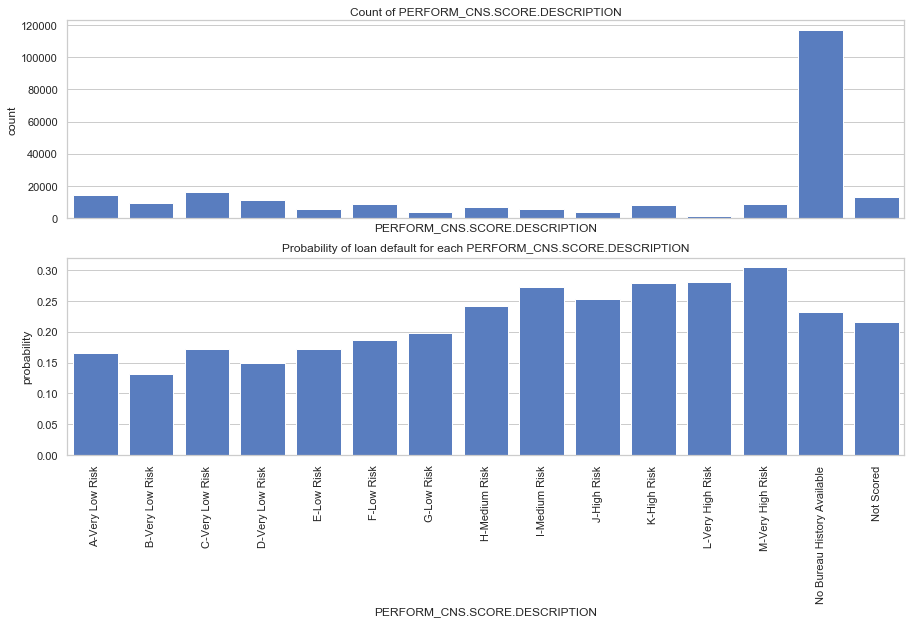

In [408]:
temp = train_df[['PERFORM_CNS.SCORE.DESCRIPTION', 'loan_default']].copy()
temp.loc[(temp['PERFORM_CNS.SCORE.DESCRIPTION'].str[0:3] == 'Not'), 'PERFORM_CNS.SCORE.DESCRIPTION'] = "Not Scored"

fig, ax = plt.subplots(nrows=2, figsize=(15, 8), sharex=True)
x = temp.groupby(['PERFORM_CNS.SCORE.DESCRIPTION'])['loan_default'].agg(['mean', 'count'])
sns.barplot(x.index, x['count'], color=c_b, ax=ax[0])
ax[0].set(title="Count of PERFORM_CNS.SCORE.DESCRIPTION", ylabel='count')
sns.barplot(x.index, x['mean'], color=c_b, ax=ax[1])
ax[1].set(title="Probability of loan default for each PERFORM_CNS.SCORE.DESCRIPTION", ylabel='probability')
plt.xticks(rotation=90)
plt.show()

In [442]:
train_df.loc[(train_df['PERFORM_CNS.SCORE.DESCRIPTION'].str[0:3] == 'Not'), 'PERFORM_CNS.SCORE.DESCRIPTION'] = "Not Scored"
test_df.loc[(test_df['PERFORM_CNS.SCORE.DESCRIPTION'].str[0:3] == 'Not'), 'PERFORM_CNS.SCORE.DESCRIPTION'] = "Not Scored"

### `PERFORM_CNS.SCORE` - Bureau Score

data type - numerical

In [405]:
gb = train_df.groupby(['PERFORM_CNS.SCORE.DESCRIPTION'])
gb[['PERFORM_CNS.SCORE', 'loan_default']].agg({'PERFORM_CNS.SCORE': ['min', 'max', 'mean', 'count'], 'loan_default': ['mean']})

PERFORM_CNS.SCORE       \
                                                                 min  max   
PERFORM_CNS.SCORE.DESCRIPTION                                               
A-Very Low Risk                                                  806  890   
B-Very Low Risk                                                  761  805   
C-Very Low Risk                                                  736  760   
D-Very Low Risk                                                  706  735   
E-Low Risk                                                       681  705   
F-Low Risk                                                       651  680   
G-Low Risk                                                       631  650   
H-Medium Risk                                                    601  630   
I-Medium Risk                                                    571  600   
J-High Risk                                                      521  570   
K-High Risk                                                      351  520   
L-Very High Risk                                                 301  350   
M-Very High Risk                                                 300  300   
No Bureau History Available                                        0    0   
Not Scored: More than 50 active Accounts found                    11   11   
Not Scored: No Activity seen on the customer (I...                16   16   
Not Scored: No Updates available in last 36 months                18   18   
Not Scored: Not Enough Info available on the cu...                17   17   
Not Scored: Only a Guarantor                                      14   14   
Not Scored: Sufficient History Not Available                      15   15   

                                                                        \
                                                          mean   count   
PERFORM_CNS.SCORE.DESCRIPTION                                            
A-Very Low Risk                                     827.662631   14124   
B-Very Low Risk                                     774.183893    9201   
C-Very Low Risk                                     741.899221   16045   
D-Very Low Risk                                     715.958091   11358   
E-Low Risk                                          691.517437    5821   
F-Low Risk                                          666.064467    8485   
G-Low Risk                                          640.853561    3988   
H-Medium Risk                                       617.031947    6855   
I-Medium Risk                                       586.832644    5557   
J-High Risk                                         549.876734    3748   
K-High Risk                                         440.594177    8277   
L-Very High Risk                                    326.601411    1134   
M-Very High Risk                                    300.000000    8776   
No Bureau History Available                           0.000000  116950   
Not Scored: More than 50 active Accounts found       11.000000       3   
Not Scored: No Activity seen on the customer (I...   16.000000    2885   
Not Scored: No Updates available in last 36 months   18.000000    1534   
Not Scored: Not Enough Info available on the cu...   17.000000    3672   
Not Scored: Only a Guarantor                         14.000000     976   
Not Scored: Sufficient History Not Available         15.000000    3765   

                                                   loan_default  
                                                           mean  
PERFORM_CNS.SCORE.DESCRIPTION                                    
A-Very Low Risk                                        0.165746  
B-Very Low Risk                                        0.131290  
C-Very Low Risk                                        0.172639  
D-Very Low Risk                                        0.149586  
E-Low Risk                                             0.171792  
F-Low Risk                                      

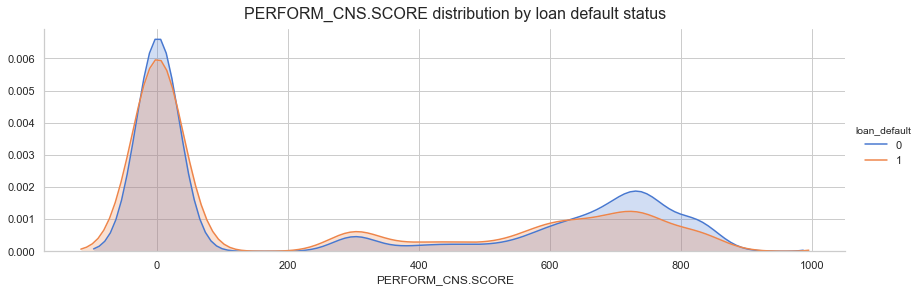

In [406]:
facet = sns.FacetGrid(train_df, hue = 'loan_default', size=4, aspect=3)
facet.fig.suptitle(('PERFORM_CNS.SCORE distribution by loan default status'), fontsize=16, y=1.01)
facet.map(sns.kdeplot, 'PERFORM_CNS.SCORE', shade=True)
facet.add_legend()
plt.show()

### `NO.OF_INQUIRIES` - Enquries done by the customer for loans

data type - numerical

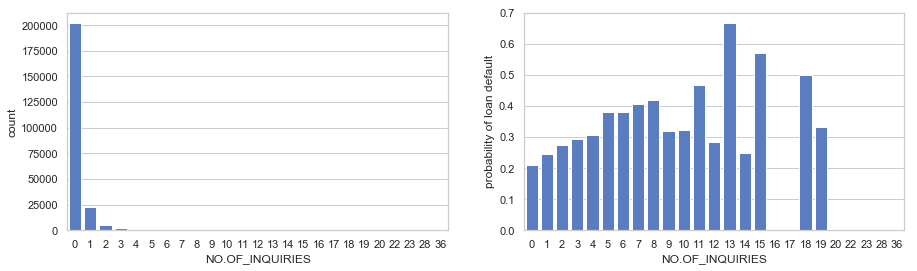

In [411]:
fig, ax = plt.subplots(ncols=2, figsize=(15,4))
sns.countplot(train_df['NO.OF_INQUIRIES'], color=c_b, ax=ax[0])
x = train_df.groupby(['NO.OF_INQUIRIES'])['loan_default'].mean()
sns.barplot(x.index, x.values, color=c_b, ax=ax[1])
ax[1].set(title='', ylabel='probability of loan default')
plt.show()

### `AVERAGE.ACCT.AGE` - Average loan tenure

data type - numeric (years)

In [420]:
train_df['AVERAGE.ACCT.AGE'] = train_df['AVERAGE.ACCT.AGE'].str.split().apply(lambda x: (int(x[0][0:-3]) * 12) + int(x[1][0:-3]))
test_df['AVERAGE.ACCT.AGE'] = test_df['AVERAGE.ACCT.AGE'].str.split().apply(lambda x: (int(x[0][0:-3]) * 12) + int(x[1][0:-3]))

In [439]:
train_df['AVERAGE.ACCT.AGE'] = train_df['AVERAGE.ACCT.AGE'] / 12
test_df['AVERAGE.ACCT.AGE'] = test_df['AVERAGE.ACCT.AGE'] / 12

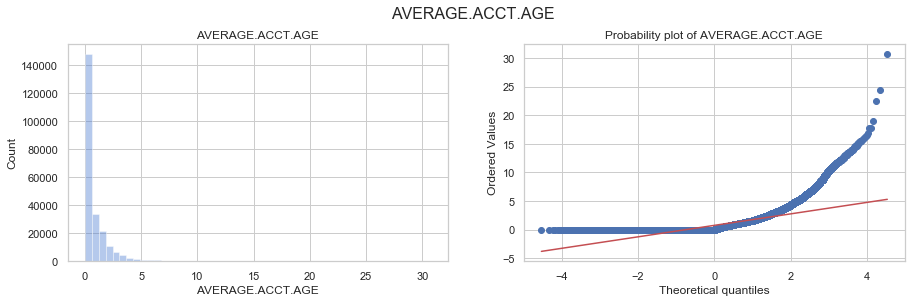

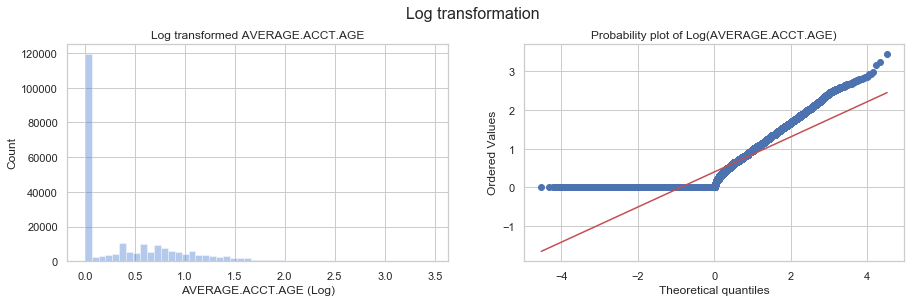

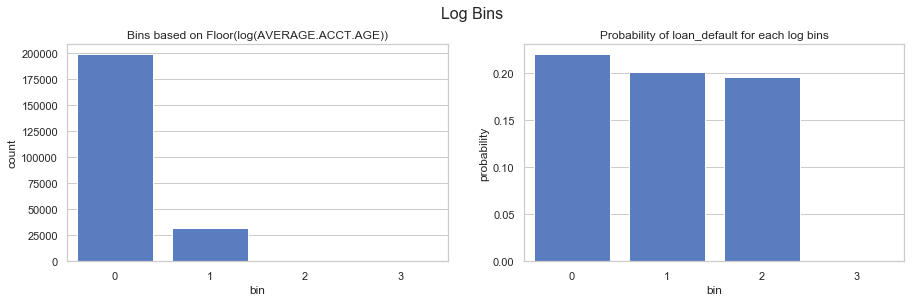

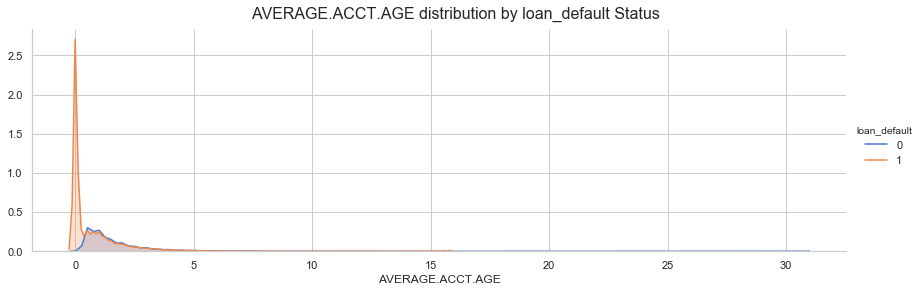

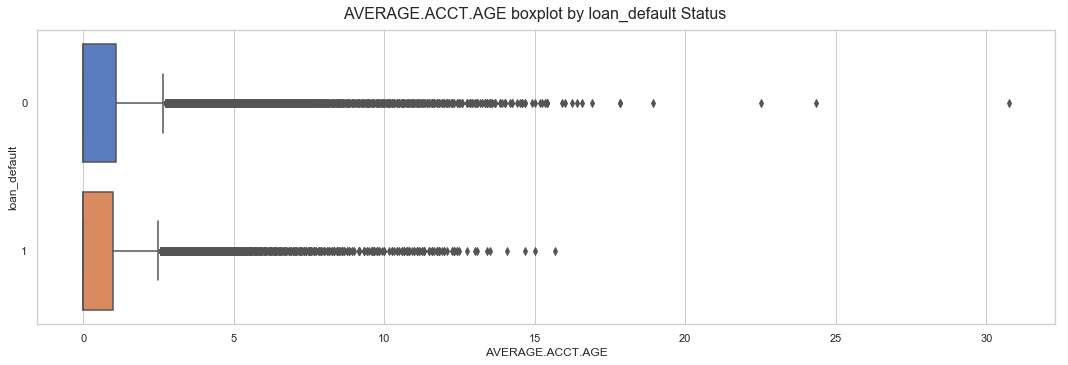

In [465]:
plot_num_dis(train_df, 'AVERAGE.ACCT.AGE', 'loan_default', exclude=['qb', 'bc'])

### `CREDIT.HISTORY.LENGTH` - Time since first loan

data type - numeric (years)

In [446]:
train_df['CREDIT.HISTORY.LENGTH'] = train_df['CREDIT.HISTORY.LENGTH'].str.split().apply(lambda x: (int(x[0][0:-3]) * 12) + int(x[1][0:-3]))
test_df['CREDIT.HISTORY.LENGTH'] = test_df['CREDIT.HISTORY.LENGTH'].str.split().apply(lambda x: (int(x[0][0:-3]) * 12) + int(x[1][0:-3]))

In [448]:
train_df['CREDIT.HISTORY.LENGTH'] = train_df['CREDIT.HISTORY.LENGTH'] / 12
test_df['CREDIT.HISTORY.LENGTH'] = test_df['CREDIT.HISTORY.LENGTH'] / 12

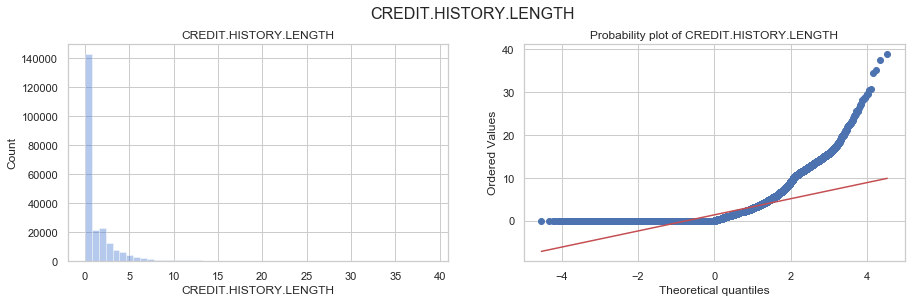

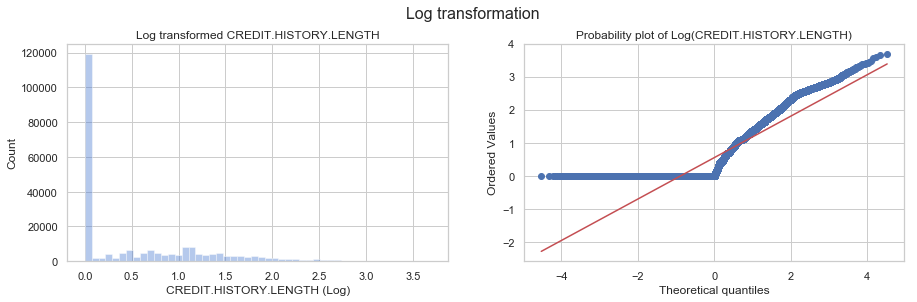

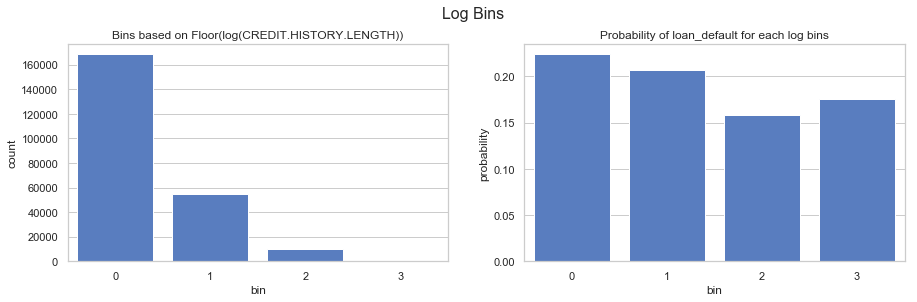

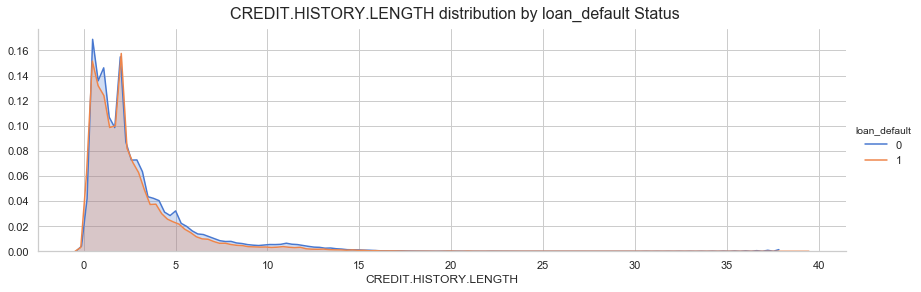

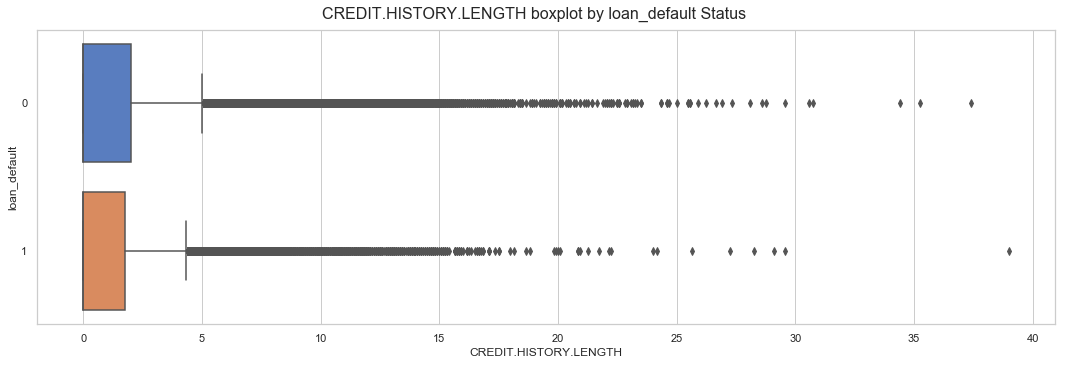

In [466]:
plot_num_dis(train_df, 'CREDIT.HISTORY.LENGTH', 'loan_default', exclude=['qb', 'bc'])

In [459]:
train_df[(train_df['CREDIT.HISTORY.LENGTH'] == 0)]['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

No Bureau History Available    115842
Not Scored                       2839
M-Very High Risk                  308
K-High Risk                        59
I-Medium Risk                      24
L-Very High Risk                   12
H-Medium Risk                      12
J-High Risk                        10
F-Low Risk                          8
A-Very Low Risk                     5
G-Low Risk                          4
D-Very Low Risk                     2
B-Very Low Risk                     2
Name: PERFORM_CNS.SCORE.DESCRIPTION, dtype: int64

- For credit history length 0, most of the users has Bureau score 0.

### `NEW.ACCTS.IN.LAST.SIX.MONTHS` - New loans taken by the customer in last 6 months before the disbursment

data type - numeric

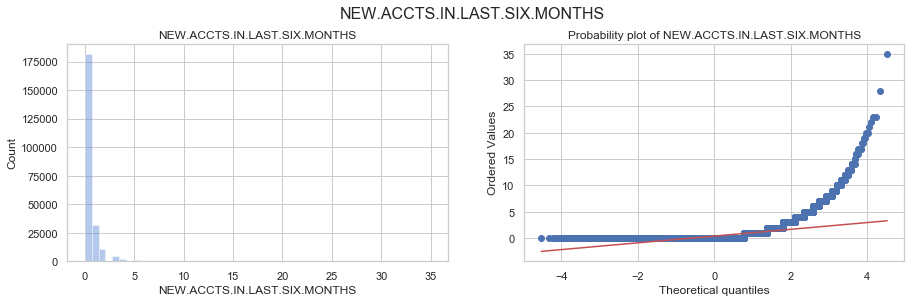

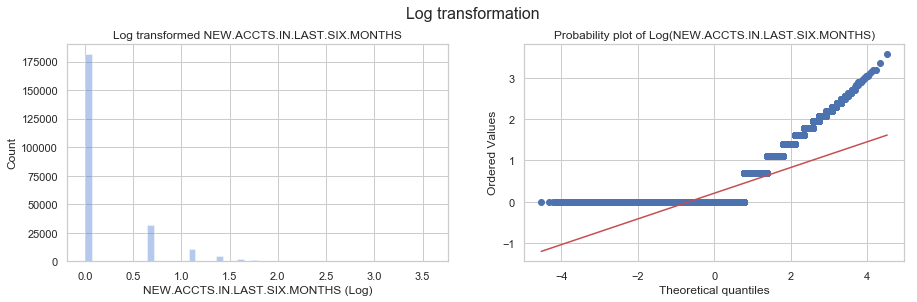

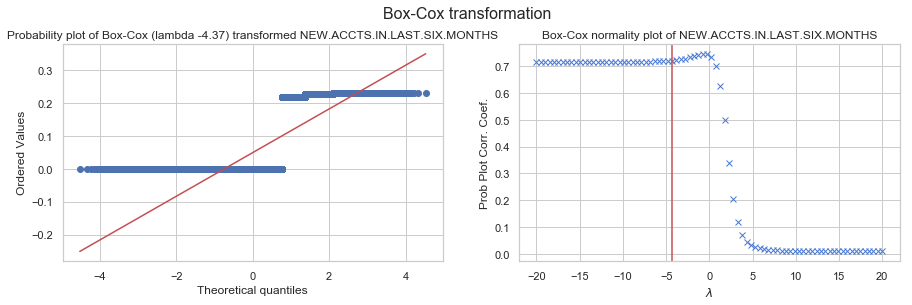

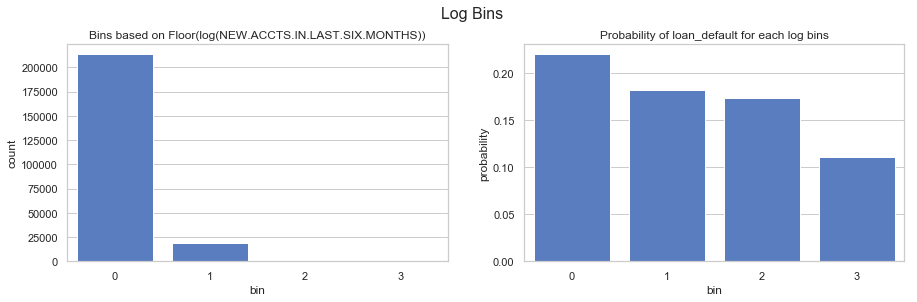

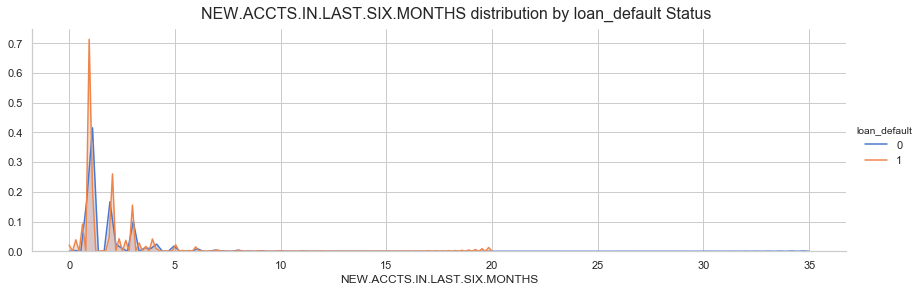

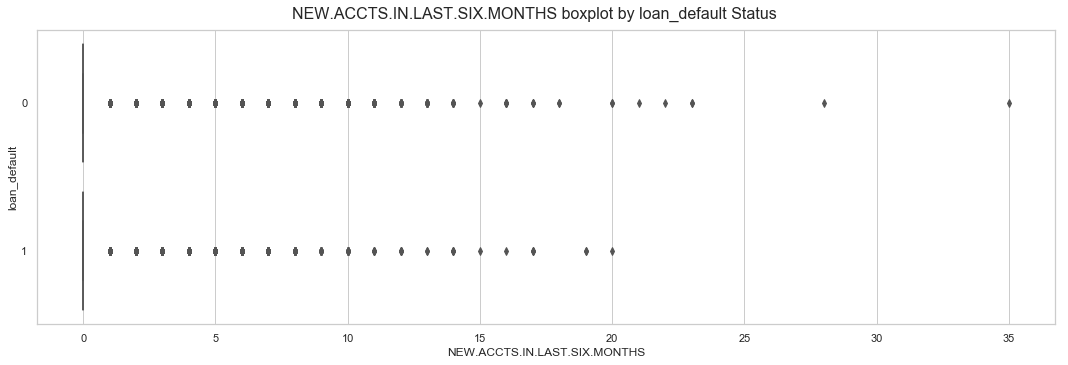

In [463]:
plot_num_dis(train_df, 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'loan_default', exclude=['qb'])

- surprisingly as number of new accounts increases, loan default probability decreases

### `DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS` - Loans defaulted in the last 6 months

data type - numeric

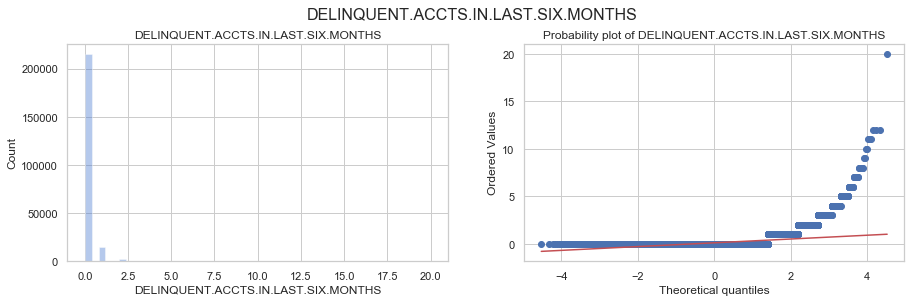

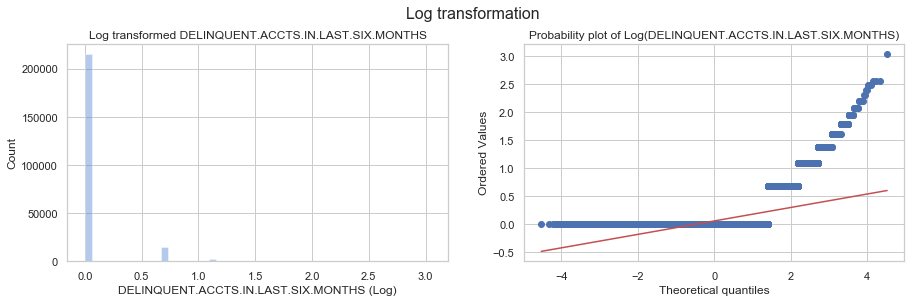

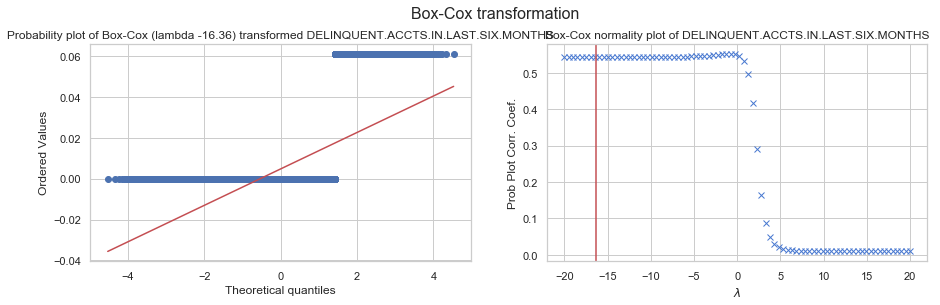

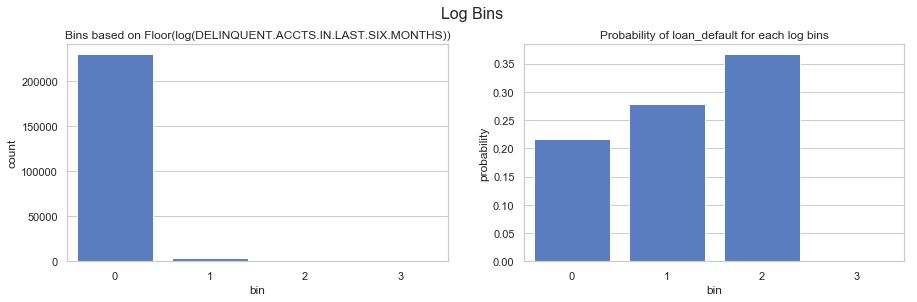

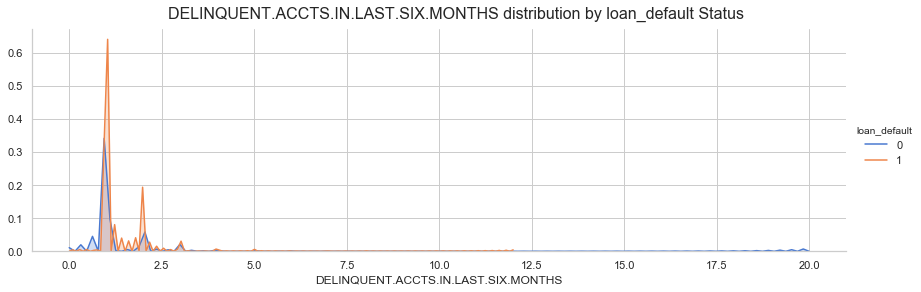

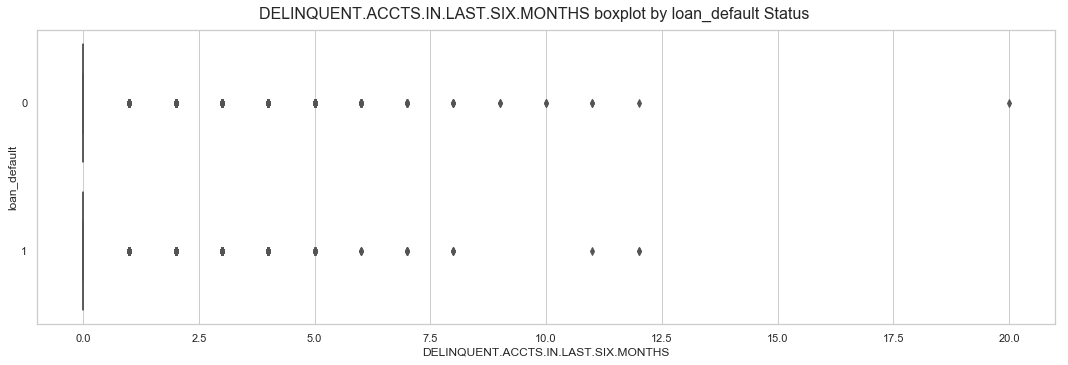

In [464]:
plot_num_dis(train_df, 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'loan_default', exclude=['qb'])

- As defaulted loans in last six months increases, probability of loan default for current loan also increases.

### `PRIMARY.INSTAL.AMT` - EMI Amount of the primary loan

data type - numerical

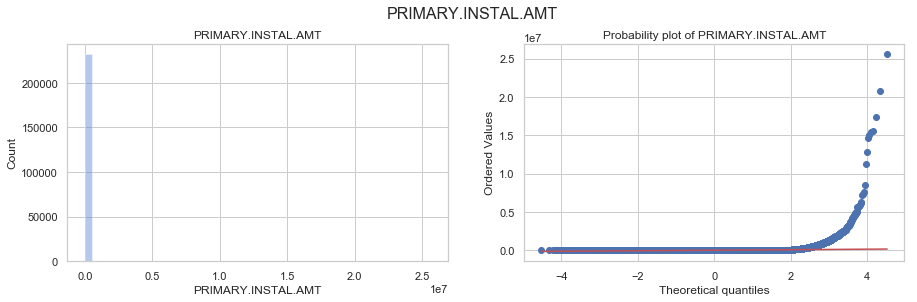

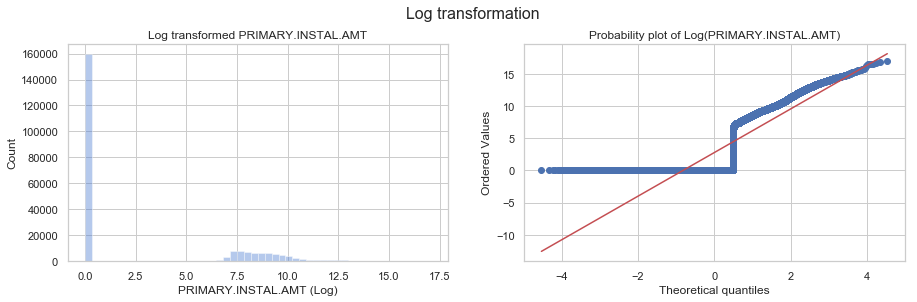

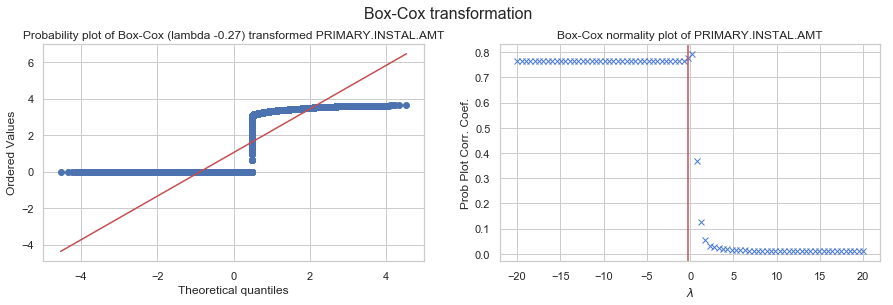

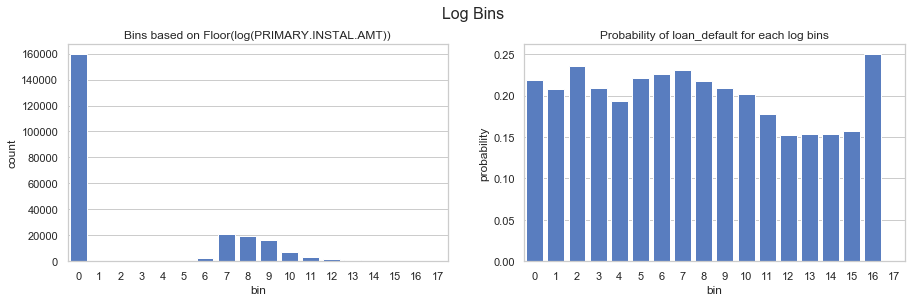

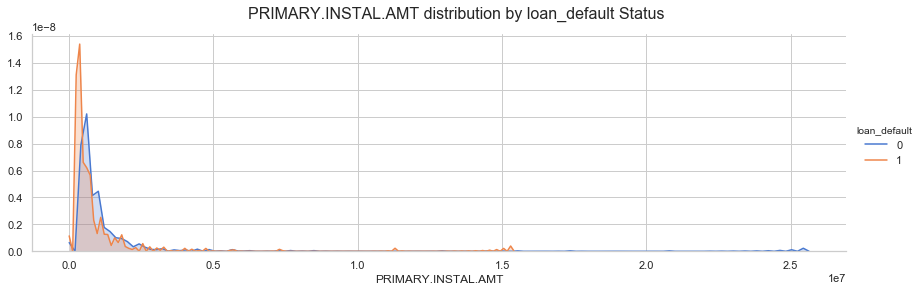

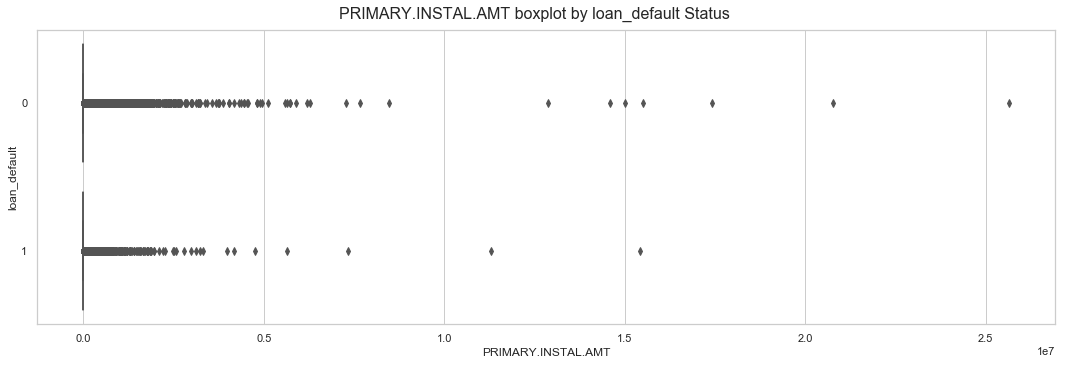

In [473]:
plot_num_dis(train_df, 'PRIMARY.INSTAL.AMT', 'loan_default', exclude=['qb'])

### `SEC.INSTAL.AMT` - EMI Amount of the secondary loan

data type - numeric

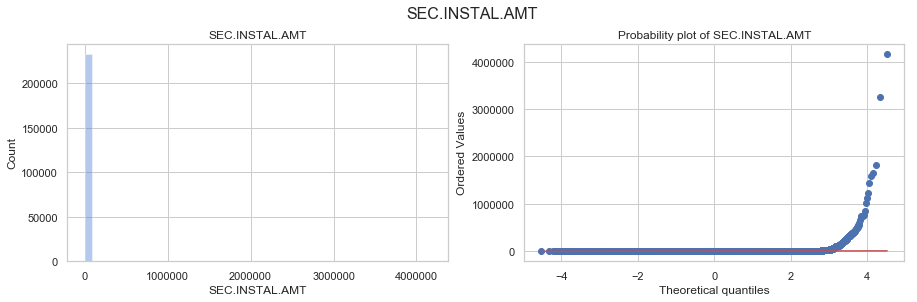

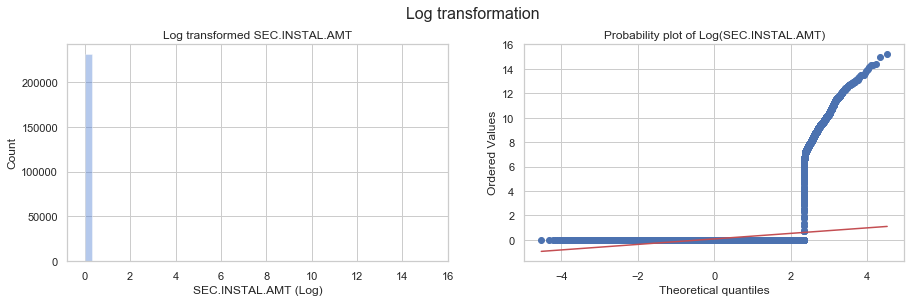

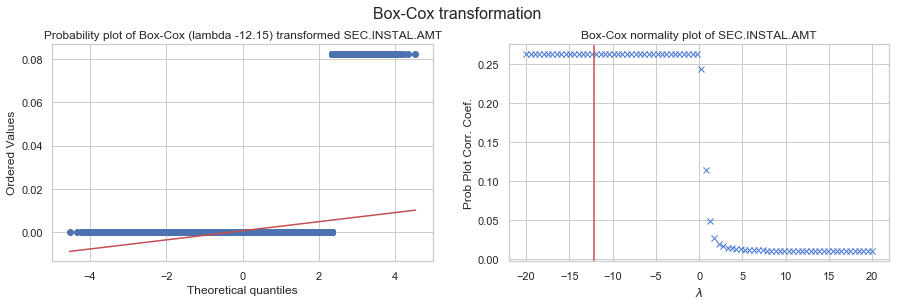

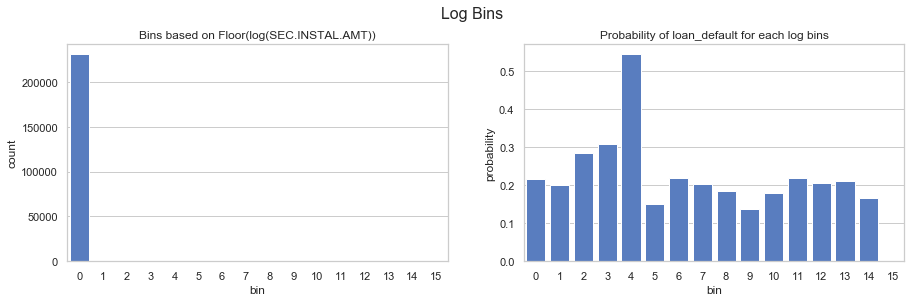

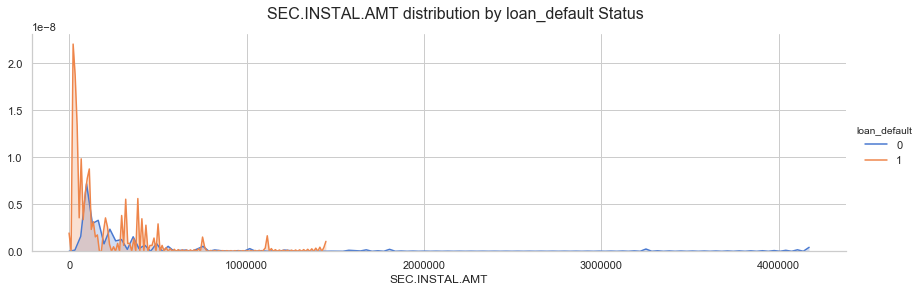

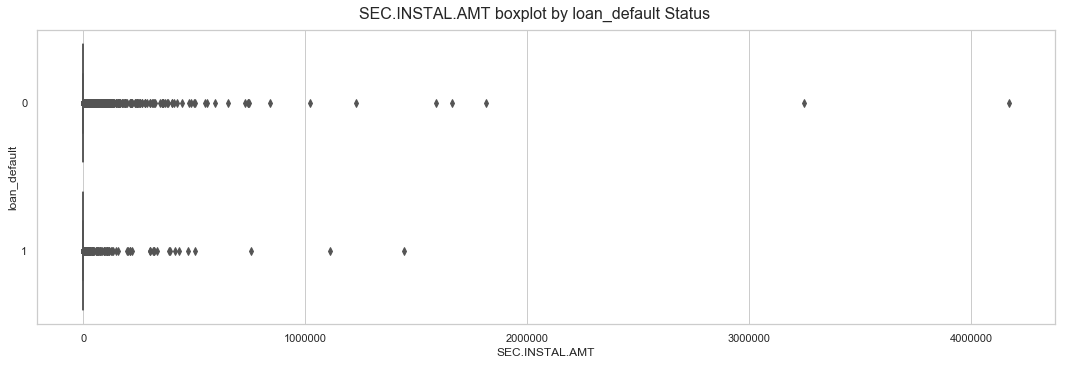

In [474]:
plot_num_dis(train_df, 'SEC.INSTAL.AMT', 'loan_default', exclude=['qb'])

### `PRI.NO.OF.ACCTS` - count of total loans taken by the customer at the time of disbursement

date type - numeric

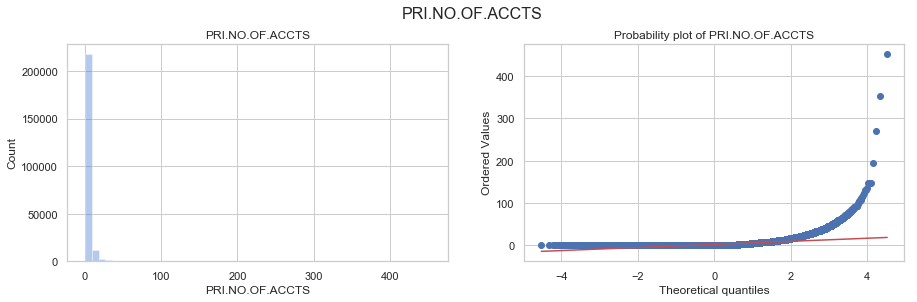

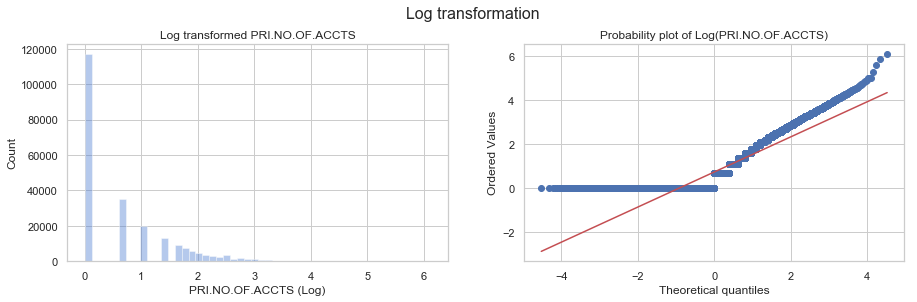

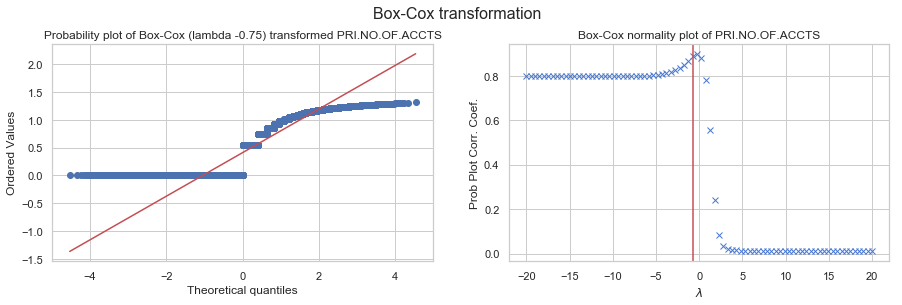

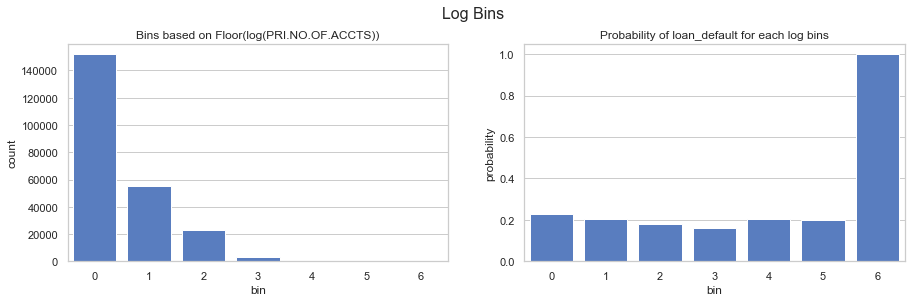

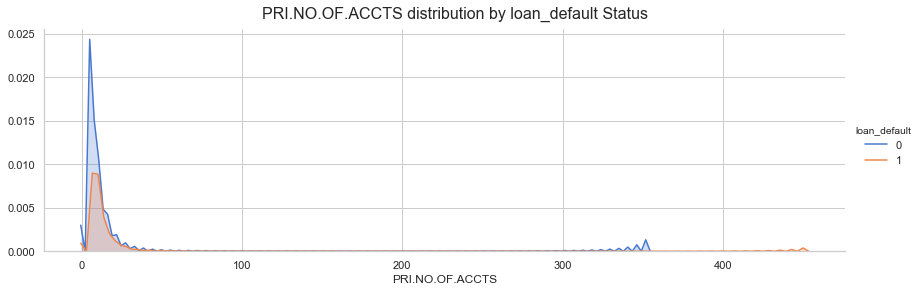

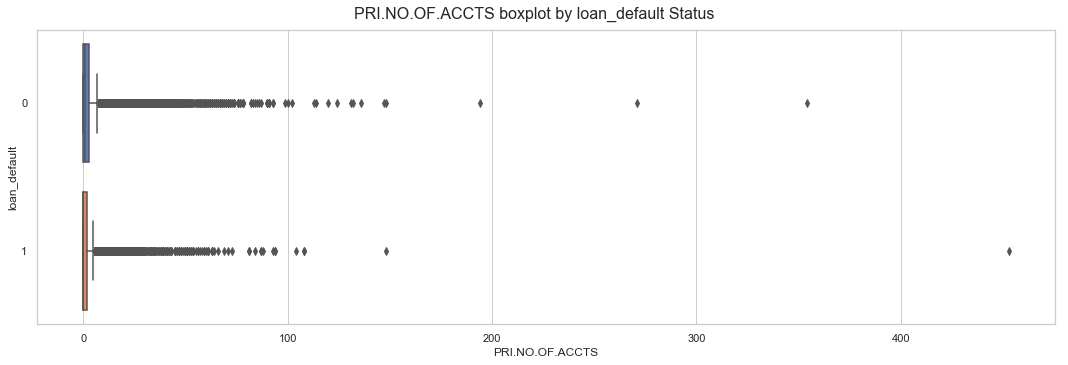

In [475]:
plot_num_dis(train_df, 'PRI.NO.OF.ACCTS', 'loan_default', exclude=['qb'])

### Q & A

In [479]:
train_df[(train_df['CREDIT.HISTORY.LENGTH'] == 0)]['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

No Bureau History Available    115842
Not Scored                       2839
M-Very High Risk                  308
K-High Risk                        59
I-Medium Risk                      24
L-Very High Risk                   12
H-Medium Risk                      12
J-High Risk                        10
F-Low Risk                          8
A-Very Low Risk                     5
G-Low Risk                          4
D-Very Low Risk                     2
B-Very Low Risk                     2
Name: PERFORM_CNS.SCORE.DESCRIPTION, dtype: int64

In [482]:
train_df[(train_df['CREDIT.HISTORY.LENGTH'] == 0)]['PRI.NO.OF.ACCTS'].value_counts()

0    115842
1      3060
2       190
3        29
4         4
7         1
5         1
Name: PRI.NO.OF.ACCTS, dtype: int64

In [483]:
train_df[(train_df['CREDIT.HISTORY.LENGTH'] == 0)]['PRI.ACTIVE.ACCTS'].value_counts()

0    116407
1      2547
2       144
3        27
7         1
4         1
Name: PRI.ACTIVE.ACCTS, dtype: int64

- if credit history is zero, it doesn't mean customer hasn't taken any loan.
- Why??

In [484]:
# if there are no accounts, there are no active accounts
train_df[(train_df['PRI.NO.OF.ACCTS'] == 0)]['PRI.ACTIVE.ACCTS'].value_counts()

0    116950
Name: PRI.ACTIVE.ACCTS, dtype: int64

In [481]:
# if active accounts are zero than all ther snaction, outstanding, and disbursed amount are zero
train_df[(train_df['PRI.ACTIVE.ACCTS'] == 0)]['PRI.SANCTIONED.AMOUNT'].value_counts()

0    137016
Name: PRI.SANCTIONED.AMOUNT, dtype: int64

In [485]:
((train_df['PRI.CURRENT.BALANCE'] - train_df['PRIMARY.INSTAL.AMT']) < 0).sum()

18067

- There are 18067 records in which primary installment ammount is higher than outstanding amount.
- Why?? How??

In [486]:
(train_df['PRI.CURRENT.BALANCE'] < 0).sum()

448

- There are only 448 customers, who has -ve outstanding amount.

In [488]:
((train_df['PRI.DISBURSED.AMOUNT'] - train_df['PRI.CURRENT.BALANCE']) < 0).sum()

7239

In [490]:
show_all_pandas(train_df[((train_df['PRI.DISBURSED.AMOUNT'] - train_df['PRI.CURRENT.BALANCE']) < 0)].head(20))

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,cus_age
20,590630,58013,69650,84.71,67,22807,45,1497,1978-11-01,Self employed,2018-10-20,6,1998,1,1,0,0,0,0,750,C-Very Low Risk,9,1,0,134499,32198,32198,0,0,0,0,0,0,557,0,1,0,0.500000,0.833333,1,0,39
73,433647,48468,65500,77.86,78,17014,45,2100,1980-01-01,Salaried,2018-08-11,4,1646,1,1,0,0,0,0,17,Not Scored,1,1,0,58558,48220,48220,0,0,0,0,0,0,0,0,1,0,0.166667,0.166667,0,1,38
263,541538,57859,65368,89.65,130,15218,86,1044,1957-02-01,Self employed,2018-09-27,6,1570,1,1,0,0,0,0,739,C-Very Low Risk,2,1,0,413200,35441,35441,0,0,0,0,0,0,286,0,1,0,0.416667,0.833333,0,0,61
300,647023,47849,66636,74.28,130,15218,86,1044,1979-09-22,Self employed,2018-10-31,6,1570,1,0,0,1,0,0,635,G-Low Risk,1,1,0,171164,154000,154000,0,0,0,0,0,0,0,0,0,0,0.750000,0.750000,0,0,39
355,582570,47895,66636,74.28,130,15218,86,1029,1980-10-10,Self employed,2018-10-16,6,1570,1,1,0,0,0,0,300,M-Very High Risk,3,3,3,1501756,1125000,1125000,0,0,0,0,0,0,55538,0,0,0,3.916667,5.916667,0,0,38
390,620526,56263,73672,78.73,130,22637,86,1042,1968-06-01,Salaried,2018-10-25,6,1570,1,1,0,0,0,0,679,F-Low Risk,3,1,0,420820,330000,330000,0,0,0,0,0,0,0,0,0,0,0.916667,1.500000,0,0,50
411,617623,44349,66890,68.77,34,18680,45,987,1979-06-22,Self employed,2018-10-25,6,1835,1,1,0,0,0,0,15,Not Scored,1,1,0,1850444,1850000,1850000,0,0,0,0,0,0,16349,0,1,0,0.083333,0.083333,0,0,39
412,595964,44599,65610,70.11,34,18680,45,1019,1973-06-01,Self employed,2018-10-21,6,1835,1,1,0,0,0,0,737,C-Very Low Risk,3,2,0,198174,193000,193000,0,0,0,0,0,0,0,0,0,0,1.333333,2.083333,0,1,45
414,490258,37439,55702,70.02,34,18680,45,1027,1981-09-01,Self employed,2018-09-05,6,1835,1,1,0,0,0,0,662,F-Low Risk,4,1,0,40028,40000,40000,0,0,0,0,0,0,0,0,1,0,0.750000,1.583333,0,0,37
437,541238,41394,66500,64.66,34,18680,45,1019,1974-06-01,Salaried,2018-09-27,6,1835,1,1,0,0,0,0,602,H-Medium Risk,8,2,0,273343,250000,250000,0,0,0,0,0,0,1267,0,0,0,1.416667,3.500000,0,0,44


- 7239 customers has higher outstanding amount than total disbursed ammount
- Why??
- maybe because outstanding amount is primary ammount + interest. which means customer hasn't paid any installment yet, which can means customer has taken this loan within 1 month.

In [491]:
((train_df['PRI.OVERDUE.ACCTS'] - train_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']) < 0).sum()

8262

- 8262 customers has total default account less than number of default in last 6 months
- Why?

In [478]:
show_all_pandas(train_df[train_df['PRIMARY.INSTAL.AMT'] > 5000000])

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,cus_age
39110,624215,54303,70074,78.49,136,14189,86,3724,1986-03-23,Salaried,2018-10-26,8,200,1,1,0,0,0,0,585,I-Medium Risk,54,17,2,8836588,13276190,13279704,0,0,0,0,0,0,15518546,0,2,4,1.166667,4.250000,0,0,32
53991,456958,48443,67351,77.21,5,18130,86,3336,1999-09-13,NaN,2018-08-22,9,632,1,0,0,0,1,0,300,M-Very High Risk,9,4,1,11707270,10025000,11525000,0,0,0,0,0,0,12870191,0,5,0,0.583333,4.250000,1,0,18
68543,557983,56559,74146,78.22,5,15663,86,3328,1965-02-25,Self employed,2018-10-04,9,390,1,1,0,0,0,0,732,D-Very Low Risk,8,2,0,1090617,1287500,1287500,1,1,0,164835,258397,258397,6190803,11054,1,0,0.833333,2.083333,0,0,53
74319,476729,53580,68230,79.99,138,14178,86,3341,1980-03-04,Self employed,2018-08-30,9,879,1,0,0,0,0,1,300,M-Very High Risk,74,22,6,2974118,2786000,2791431,0,0,0,0,0,0,20766553,0,3,0,0.833333,10.916667,1,0,38
80984,467598,55959,73231,78.52,16,20940,51,2995,1984-04-16,Self employed,2018-08-28,14,1660,1,1,0,0,0,0,818,A-Very Low Risk,147,0,0,0,0,0,0,0,0,0,0,0,5903450,0,0,0,0.333333,1.166667,0,0,34
84281,451705,67682,79464,88.09,5,15663,86,3348,1976-07-01,Salaried,2018-08-21,9,653,1,1,0,0,0,0,300,M-Very High Risk,87,2,5,253920,240000,240000,0,0,0,0,0,0,7326698,0,0,0,0.416667,1.250000,0,1,42
84954,637435,48349,63420,78.05,13,14241,45,4618,1970-03-05,Salaried,2018-10-29,8,1844,1,1,0,0,0,0,526,J-High Risk,36,4,1,2093465,2539079,2529814,0,0,0,0,0,0,8470059,0,3,1,0.583333,3.750000,0,0,48
98591,431765,43649,62047,76.07,3,17431,86,552,1985-03-05,Self employed,2018-08-10,15,639,1,1,0,0,0,0,385,K-High Risk,6,4,1,4207827,3835500,3835500,0,0,0,0,0,0,15420411,0,1,2,1.250000,3.083333,0,1,33
114406,580809,50303,65910,77.38,136,23894,45,3800,1991-04-25,Salaried,2018-10-15,8,203,1,1,0,0,0,0,701,E-Low Risk,91,11,0,7010774,7687373,7687373,0,0,0,0,0,0,15019914,0,16,0,0.416667,3.416667,0,0,27
125308,518199,28429,62910,47.69,105,20292,48,1279,1988-10-20,Self employed,2018-09-19,6,1924,1,1,0,0,0,0,648,G-Low Risk,1,1,0,833998,1200000,1200000,0,0,0,0,0,0,25642806,0,0,0,2.916667,2.916667,0,0,29


__Question__ : 
1) why PRI.OVERDUE.ACCTS is lower than DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS? check unique_id : 624215

2) check unique_id : 467598. Why there is value for PRIMARY.INSTAL.AMT when PRI.ACTIVE.ACCTS is zero?